![lop](../../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Flux Processing Chain
</b>
</span>

---
**Notebook version**: `4` (25 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- This notebook demonstrates part of the flux post-processing used for fluxes from Swiss FluxNet research stations
- For a description of the different flux levels, see [Flux Processing Chain](https://www.swissfluxnet.ethz.ch/index.php/data/ecosystem-fluxes/flux-processing-chain/)
- Flux calculations (Level-1) were done in a previous step
- This notebook uses the calculated fluxes (Level-1) and applies several post-processing steps:
    - Quality flag extension (Level-2)
    - Storage correction (Level-3.1)
    - Outlier removal (Level-3.2)
- Other flux levels are currently not produced in this example:
    - Gap-filling (Level-4.1)
    - NEE Partitioning (Level-4.2)

</br>

# **User settings**
`FLUXVAR` is the name of the flux variable in the data files. In the EddyPro `_fluxnet_` output files, the flux variables we primarily use are:
  - `FC` ... CO2 flux, becomes `NEE` after storage correction (Level-3.1)
  - `LE` ... Latent heat flux (water)
  - `H` ... Sensible heat flux
  
There are more flux variables in the output file, but we rarely need them:
  - `FH2O` ... H2O flux, very important but it is the same as `ET` and `LE` but with different units
  - `ET` ... Evapotranspiration, very important but it is the same as `FH2O` and `LE` but with different units. We can easily calculte `ET` later from `LE`, e.g. in `ReddyProc`.
  - `TAU` ... Momentum flux, a measure of the turbulent transfer of momentum between the land surface and the atmosphere

In [1]:
FLUXVAR = "FN2O"  # Name of the flux variable: FC (CO2 flux), LE (latent heat, water) of H (sensible heat)
FOLDERS = [r"data"]  # Folders where data files are located, in case you want to load data from these files
SITE_LAT = 47.286417  # Latitude of site
SITE_LON = 7.733750  # Longitude of site

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import os
import importlib.metadata
import pandas as pd
from datetime import datetime
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from diive.core.io.filereader import MultiDataFileReader, search_files
from diive.core.io.files import save_parquet, load_parquet
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.fluxprocessingchain.level2_qualityflags import FluxQualityFlagsLevel2EddyPro
from diive.pkgs.fluxprocessingchain.level31_storagecorrection import FluxStorageCorrectionSinglePointEddyPro
from diive.pkgs.outlierdetection.stepwiseoutlierdetection import StepwiseOutlierDetection
from diive.pkgs.qaqc.qcf import FlagQCF
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

Loading BokehJS ...

diive version: v0.64.0


</br>

# **Docstring** for `FluxQualityFlagsLevel2EddyPro`

In [3]:
help(FluxQualityFlagsLevel2EddyPro)

Help on class FluxQualityFlagsLevel2EddyPro in module diive.pkgs.fluxprocessingchain.level2_qualityflags:

class FluxQualityFlagsLevel2EddyPro(builtins.object)
 |  FluxQualityFlagsLevel2EddyPro(df: pandas.core.frame.DataFrame, fluxcol: str, levelid: str = 'L2')
 |  
 |  Create QCF (quality-control flag) for selected flags, calculated
 |  from EddyPro's _fluxnet_ output files
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: pandas.core.frame.DataFrame, fluxcol: str, levelid: str = 'L2')
 |      Create QCF (quality-control flag) for selected flags, calculated
 |      from EddyPro's _fluxnet_ output files
 |      
 |      Args:
 |          df: Dataframe containing data from EddyPro's _fluxnet_ file
 |          fluxcol: Name of the flux variable in *df*
 |          levelid: Suffix added to output variable names
 |  
 |  angle_of_attack_test(self)
 |      Flag from EddyPro fluxnet files is an integer and looks like this, e.g.: 81
 |      The integer contains angle-of-attack test r

</br>

# **Docstring** for `FluxStorageCorrectionSinglePointEddyPro`

In [4]:
help(FluxStorageCorrectionSinglePointEddyPro)

Help on class FluxStorageCorrectionSinglePointEddyPro in module diive.pkgs.fluxprocessingchain.level31_storagecorrection:

class FluxStorageCorrectionSinglePointEddyPro(builtins.object)
 |  FluxStorageCorrectionSinglePointEddyPro(df: pandas.core.frame.DataFrame, fluxcol: str, levelid: str = 'L3.1')
 |  
 |  Estimation of storage fluxes (gases, sensible heat, latent heat) from concentrations
 |  (1-point profile) as calculated by EddyPro
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: pandas.core.frame.DataFrame, fluxcol: str, levelid: str = 'L3.1')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get(self) -> pandas.core.frame.DataFrame
 |      Return original data with storage-corrected flux and the flag
 |      indicating storage term availability
 |  
 |  report(self)
 |  
 |  showplot(self, maxflux: float)
 |  
 |  storage_correction(self)
 |  
 |  ----------------------------------------------------------------------
 |  Readonly propertie

</br>

# **Docstring** for `StepwiseOutlierDetection`

In [5]:
help(StepwiseOutlierDetection)

Help on class StepwiseOutlierDetection in module diive.pkgs.outlierdetection.stepwiseoutlierdetection:

class StepwiseOutlierDetection(builtins.object)
 |  StepwiseOutlierDetection(dataframe: pandas.core.frame.DataFrame, col: str, site_lat: float, site_lon: float, timezone_of_timestamp: str)
 |  
 |  Step-wise outlier detection in time series data
 |  
 |  The class is optimized to work in Jupyter notebooks.
 |  
 |  Quality flags that can be directly created via this class:
 |  - `.flag_missingvals_test()`: Generate flag that indicates missing records in data
 |  - `.flag_outliers_abslim_test()`: Generate flag that indicates if values in data are outside the specified range
 |  - `.flag_outliers_abslim_dtnt_test()`: Generate flag that indicates if daytime and nighttime values in data are
 |      outside their respectively specified ranges
 |  - `.flag_outliers_increments_zcore_test()`: Identify outliers based on the z-score of increments
 |  - `.flag_outliers_localsd_test()`: Identify

</br>

# **Load data** (2 options)

## Option 1: Load data from single or multiple output files
- Used to read data from the EddyPro _fluxnet_ output files

### Search files

In [6]:
filepaths = search_files(FOLDERS, "*.csv")  # Search all CSV files in folder and subfolders and store filepaths in list
filepaths = [fp for fp in filepaths if "eddypro_" in fp.stem and "_fluxnet_" in fp.stem and fp.stem.endswith("_adv")]  # Filter list and keep only EddyPro _fluxnet_ output files
filepaths

[WindowsPath('data/CH-OE2_2019_eddypro_FR-20210319-210607_fluxnet_2021-03-20T220652_adv.csv')]

### Read Files

In [7]:
data = MultiDataFileReader(filetype='EDDYPRO_FLUXNET_30MIN', filepaths=filepaths)
df_orig = data.data_df.copy()

Reading file CH-OE2_2019_eddypro_FR-20210319-210607_fluxnet_2021-03-20T220652_adv.csv ...


</br>

## Option 2: Load data from `parquet` file
- Used to continue a previous session where another flux variable was already post-processed
- For example, if you have already post-processed CO2 flux and now want to post-process H2O flux
- Also detects time resolution of time series, this info was lost when saving to the parquet file

In [ ]:
df_orig = load_parquet(filepath='df_level32_qcf.parquet')

</br>

## Check data

In [8]:
df_orig

AIR_MV  AIR_DENSITY  AIR_RHO_CP  AOA_METHOD  AXES_ROTATION_METHOD     BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_MODEL_SA  BADM_INST_HEIGHT_SA  ...  W_T_SONIC_COV_IBROM_N0008  W_T_SONIC_COV_IBROM_N0004  W_NUM_SPIKES  WD_FILTER_NREX  W_SPIKE_NREX  W_ABSLIM_NREX  W_VM97_TEST    W_KID  W_ZCD  W_ITC  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED        ZL  ZL_UNCORR
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                     ...                                                                                                                                                                                                                   
2019-01-01 01:15:00  0.023615      1.22252     1234.70         0.0                   1.0   2.62615           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...                  -0.000384                  -0.000314           1.0             0.0           3.0            0.0  800000011.0  5.32158  132.0   31.0         3.0             0.0          0.0  0.030711   0.031205
2019-01-01 01:45:00  0.023617      1.22240     1234.57         0.0                   1.0  -1.17256           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...                  -0.000298                  -0.000177           3.0             0.0           3.0            0.0  800000001.0  6.05053   90.0   21.0         2.0             0.0          0.0  0.018084   0.017335
2019-01-01 02:15:00  0.023607      1.22296     1235.09         0.0                   1.0   1.65116           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...                  -0.000955                  -0.000718           6.0             0.0          12.0            0.0  800000111.0  6.63903   72.0   26.0         2.0             0.0          0.0  0.025143   0.025785
2019-01-01 02:45:00  0.023594      1.22368     1235.75         0.0                   1.0   3.91349           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...                  -0.000977                  -0.000688           4.0             0.0           6.0            0.0  800000000.0  6.26476   70.0   29.0         2.0             0.0          0.0  0.035294   0.035602
2019-01-01 03:15:00  0.023589      1.22395     1235.96         0.0                   1.0  -4.53499           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...                  -0.001068                  -0.000806           1.0             0.0           1.0            0.0  800000011.0  6.65347   75.0   31.0         3.0             0.0          0.0  0.032152   0.031745
...                       ...          ...         ...         ...                   ...       ...           ...                ...                 ...                 ...           ...                     ...                      ...                 ...                  ...  ...                        ...                        ...           ...             ...           ...            ...          ...      ...    ...    ...         ...             ...          ...       ...        ...
2019-12-31 22:45:00  0.023096      1.25146     1261.69         0.0                   1.

In [9]:
df_orig.describe()

AIR_MV   AIR_DENSITY    AIR_RHO_CP  AOA_METHOD  AXES_ROTATION_METHOD         BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_MODEL_SA  BADM_INST_HEIGHT_SA  ...  W_T_SONIC_COV_IBROM_N0008  W_T_SONIC_COV_IBROM_N0004  W_NUM_SPIKES  WD_FILTER_NREX  W_SPIKE_NREX  W_ABSLIM_NREX   W_VM97_TEST         W_KID         W_ZCD         W_ITC    W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED            ZL     ZL_UNCORR
count  10079.000000  10079.000000  10079.000000     10079.0               10079.0  10073.000000       10079.0       1.007900e+04         10079.00000             10079.0  10079.000000                 10079.0                  10079.0                 0.0         10079.000000  ...               10079.000000               10079.000000  10079.000000         10079.0  10079.000000        10079.0  1.007900e+04  10079.000000  10079.000000  10079.000000  10079.000000         10079.0      10079.0  10079.000000  10079.000000
mean       0.024351      1.186080   1199.106639         0.0                   1.0     -2.526856           0.0       4.728640e+01             7.73375               452.0      0.053810                    20.0                     30.0                 NaN             2.235855  ...                   0.002620                   0.001561      4.278797             0.0      6.582498            0.0  8.001260e+08      9.246910    936.793630     26.527036      2.121540             0.0          0.0     -0.282342     -0.300967
std        0.000760      0.038469     36.031404         0.0                   0.0    262.778088           0.0       7.105780e-15             0.00000                 0.0      0.020478                     0.0                      0.0                 NaN             0.039878  ...                   0.048110                   0.043762      5.262890             0.0      7.785469            0.0  3.314349e+05     20.717593   1805.250219     21.910103      1.161246             0.0          0.0     15.797407     16.779108
min        0.022652      1.072750   1088.550000         0.0                   1.0 -25916.500000           0.0       4.728640e+01             7.73375               452.0      0.000530                    20.0                     30.0                 NaN             2.170000  ...                  -2.235980                  -2.143310      0.000000             0.0      0.000000            0.0  8.000000e+08      2.857240      0.000000      0.000000      1.000000             0.0          0.0  -1577.020000  -1675.740000
25%        0.023763      1.157045   1172.560000         0.0                   1.0     -0.906899           0.0       4.728640e+01             7.73375               452.0      0.049290                    20.0                     30.0                 NaN             2.170000  ...                  -0.002253                  -0.001718      1.000000             0.0      1.000000            0.0  8.000000e+08      6.545300     12.000000      9.000000      1.000000             0.0          0.0     -0.082901     -0.085736
50%        0.024308      1.187440   1199.610000         0.0                   1.0      0.521113           0.0       4.728640e+01             7.73375               452.0      0.063860                    20.0                     30.0                 NaN             2.260000  ...                   0.000236                   0.000233      3.000000             0.0      4.000000            0.0  8.000000e+08      7.601730    127.000000     20.000000      2.000000             0.0          0.0      0.001400      0.000989
75%        0.024906      1.215860   1226.435000         0.0                   1.0      1.926960           0.0       4.728640e+01             7.73375               452.0      0.065160                    20.0                     30.0                 NaN             2.260000  ...                   0.004424                   0.003467      6.000000             0.0     10.000000            

In [10]:
sstats(df_orig[FLUXVAR])

FN2O
STARTDATE      2019-01-01 01:15
ENDDATE        2020-01-01 00:45
PERIOD        364 days 23:30:00
NOV                       10073
MISSING                    7447
MISSING_PERC          42.505708
MEAN                   0.847579
SD                     3.771886
VAR                   14.227126
SD/MEAN                4.450188
SUM                 8537.663643
MEDIAN                 0.533445
MIN                    -254.542
MAX                     41.9396
P01                   -4.319542
P05                   -0.999493
P25                    0.175596
P75                      1.1832
P95                    4.520106
P99                    9.023523

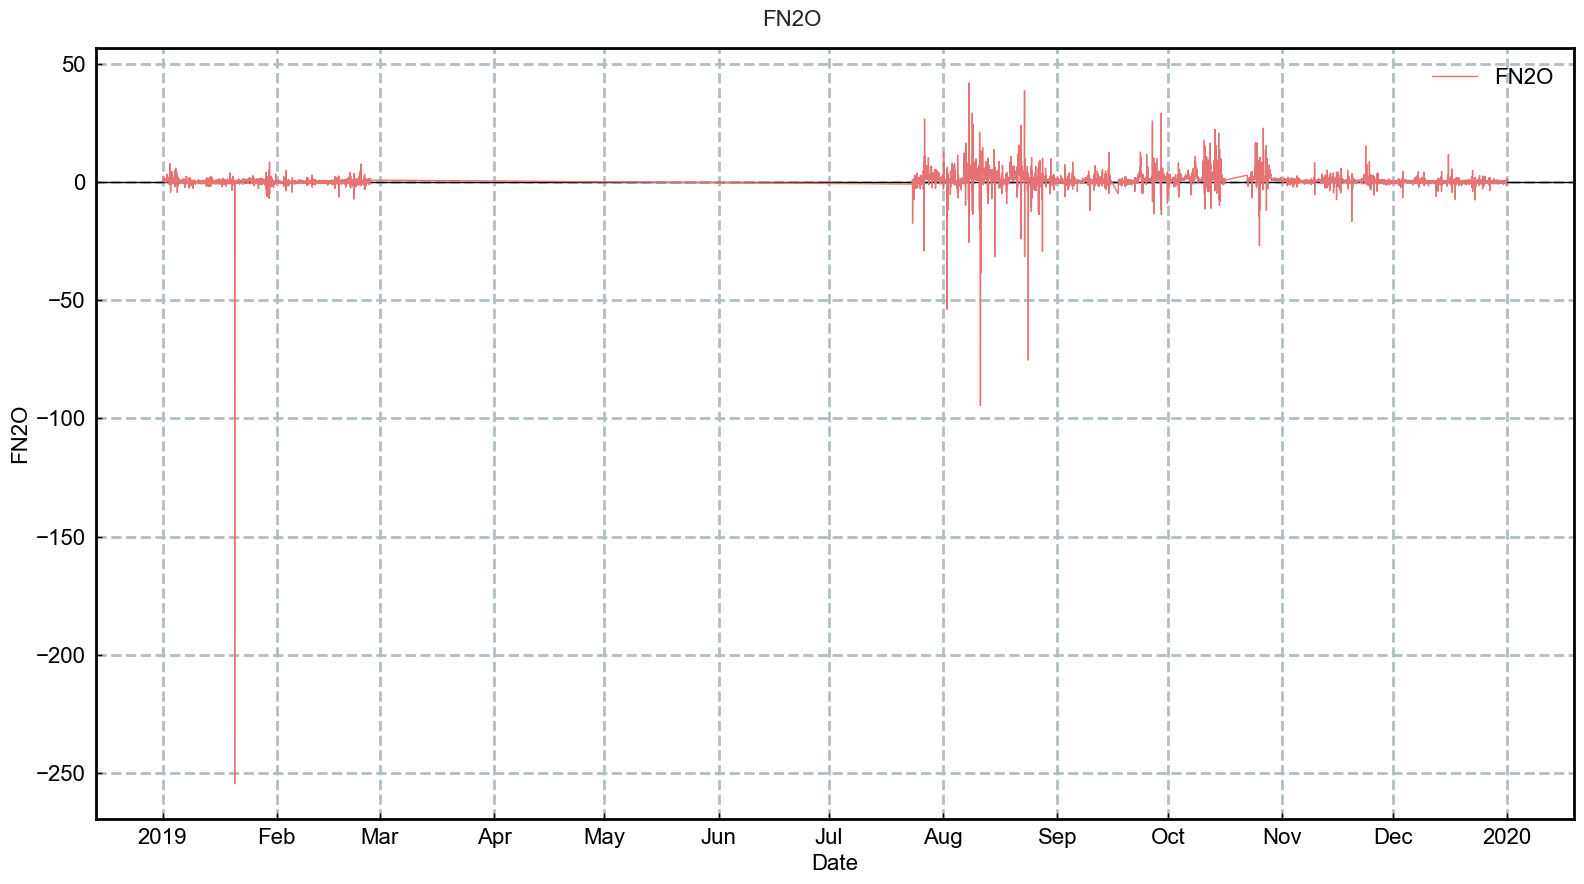

In [11]:
# TimeSeries(series=df_orig[FLUXVAR]).plot_interactive()
TimeSeries(series=df_orig[FLUXVAR]).plot()

</br>

</br>

# **Level-2: Quality flag extension**

> Extract additional quality information from the EddyPro `_fluxnet_` output file and store it in newly added quality flags.



Note that the USTAR filtering is not part of the Level-2 calculations.

</br>

## Inititate calculations

In [12]:
fluxqc = FluxQualityFlagsLevel2EddyPro(fluxcol=FLUXVAR, df=df_orig, levelid='L2')

Detected base variable N2O for FN2O.


</br>

</br>

## Flag: **Missing values** test
- Flag calculated here from missing flux values in the EddyPro output file

In [13]:
fluxqc.missing_vals_test()

Generating new flag variable FLAG_L2_FN2O_MISSING_TEST, newly calculated from output variable FN2O,with flag 0 (good values) where FN2O is available, flag 2 (bad values) where FN2O is missing ...


</br>

</br>

## Flag: **SSITC** tests
- Flag calculated in EddyPro
- Combination of the two partial tests *steady state test* and *developed turbulent conditions test*
- This notebook expects the SSITC flag to follow the flagging policy according to Mauder and Foken 2004: `0` for best quality fluxes, `1` for fluxes suitable for general analysis such as annual
budgets (although this is debatable) and `2` for fluxes that should be discarded from the dataset

In [14]:
fluxqc.ssitc_test()

Generating new flag variable FLAG_L2_FN2O_SSITC_TEST, values taken from output variable FN2O_SSITC_TEST ...


</br>

</br>

## Flag: **Completeness** test
- Flag calculated here from the gas number of records percentage in EddyPro output file
- Checks gas number of records available for each averaging Interval

In [15]:
fluxqc.gas_completeness_test()

Generating new flag variable FLAG_L2_FN2O_COMPLETENESS_TEST, newly calculated from output variable N2O_NR_PERC, with flag 0 (good values) where N2O_NR_PERC >= 0.99, flag 1 (ok values) where N2O_NR_PERC >= 0.97 and < 0.99, flag 2 (bad values) < 0.97...


</br>

</br>

## Flag: **Spectral correction factor** test
- Flag calculated here from the gas `scf` variable in EddyPro output file

In [16]:
fluxqc.spectral_correction_factor_test()

Generating new flag variable FLAG_L2_FN2O_SCF_TEST, newly calculated from output variable FN2O_SCF, withflag 0 (good values) where FN2O_SCF < 2, flag 1 (ok values) where FN2O_SCF >= 2 and < 4, flag 2 (bad values) where FN2O_SCF >= 4...


</br>

</br>

## Flag: **Signal strength / AGC** / window dirtiness test (if available)
- Flag calculated here from the signal strength / AGC variable for the gas analyzer in EddyPro output file

<div class="alert alert-block alert-danger">
    <b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>

In [ ]:
SIGNAL_STRENGTH_COL = 'CUSTOM_AGC_MEAN'  # Name of the column storing the signal strength, typically 'CUSTOM_AGC_MEAN' for LI-7500, 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN' for LI-7200, or something similar
SIGNAL_STRENGTH_THRESHOLD = 90  # Signal strength threshold, flux values where threshold is exceeded are flagged as rejected
SIGNAL_STRENGTH_METHOD = 'discard above'  # 'discard above' flags fluxes where signal strength > threshold, 'discard below' where signal strength < threshold

In [ ]:
# TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot_interactive()
TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot()

In [ ]:
fluxqc.signal_strength_test(signal_strength_col=SIGNAL_STRENGTH_COL,
                            method=SIGNAL_STRENGTH_METHOD, 
                            threshold=SIGNAL_STRENGTH_THRESHOLD)

</br>

</br>

## Flags: **Raw data screening** tests
- Flags were calculated in EddyPro

In [17]:
fluxqc.raw_data_screening_vm97_tests(spikes=True,
                                     amplitude=True,
                                     dropout=True,
                                     abslim=False,
                                     skewkurt_hf=False,
                                     skewkurt_sf=False,
                                     discont_hf=False,
                                     discont_sf=False)

Generating new flag variable FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST, values taken from output variable N2O_VM97_TEST from position 1, based on N2O, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed (for hard flags) or flag 1 (ok values) where test failed (for soft flags) ...
Generating new flag variable FLAG_L2_FN2O_N2O_VM97_AMPLITUDE_RESOLUTION_HF_TEST, values taken from output variable N2O_VM97_TEST from position 2, based on N2O, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed (for hard flags) or flag 1 (ok values) where test failed (for soft flags) ...
Generating new flag variable FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST, values taken from output variable N2O_VM97_TEST from position 3, based on N2O, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed (for hard flags) or flag 1 (ok values) where test failed (for soft flags) ...


</br>

</br>

## Flag: **Angle-of-attack** test (optional)
- Flag was calculated in EddyPro

In [18]:
fluxqc.angle_of_attack_test()

Generating new flag variable FLAG_L2_FN2O_VM97_AOA_HF_TEST, values taken from output variable VM97_AOA_HF, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed ...


</br>

</br>

## Add flags to dataset

In [19]:
# print(fluxqc.fluxflags)
df_level2 = fluxqc.get()

++Adding new column FLAG_L2_FN2O_MISSING_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FN2O_SSITC_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FN2O_COMPLETENESS_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FN2O_SCF_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FN2O_N2O_VM97_AMPLITUDE_RESOLUTION_HF_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FN2O_VM97_AOA_HF_TEST (Level-2 quality flag) to main data ...


</br>

</br>

## Available `Level-2` variables
- This shows all available Level-2 variables, also the ones created previously for other fluxes

In [20]:
[x for x in df_level2.columns if 'L2' in x]

['FLAG_L2_FN2O_MISSING_TEST',
 'FLAG_L2_FN2O_SSITC_TEST',
 'FLAG_L2_FN2O_COMPLETENESS_TEST',
 'FLAG_L2_FN2O_SCF_TEST',
 'FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST',
 'FLAG_L2_FN2O_N2O_VM97_AMPLITUDE_RESOLUTION_HF_TEST',
 'FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST',
 'FLAG_L2_FN2O_VM97_AOA_HF_TEST']

</br>

</br>

# **Level-3.1: Storage correction**

- Adds storage term to flux

## Inititate calculations

In [21]:
s = FluxStorageCorrectionSinglePointEddyPro(df=df_level2, fluxcol=FLUXVAR)

Detected base variable N2O for FN2O.
Detected storage variable SN2O_SINGLE for FN2O.


</br>

## Calculate storage correction
- The flux storage term (single point) is added to the flux
- For some records, the storage term can be missing. In such cases, missing terms are gap-filled using random forest
- Without gap-filling the storage term, we can lose an additional e.g. 2-3% of flux data

Calculating storage-corrected flux FN2O_L3.1 from flux FN2O and storage term SN2O_SINGLE ...

Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Adding continuous record number ...
Added new column .RECORDNUMBER with record numbers from 1 to 17520.

Sanitizing timestamp ...
Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
Sorting timestamp TIMESTAMP_MIDDLE ascending ... Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2019-01-01 01:15:00 and 2020-01-01 00:45:00 ... Building random forest model based on data between 2019-01-01 01:15:00 and 2020-01-01 00:45:00 ...


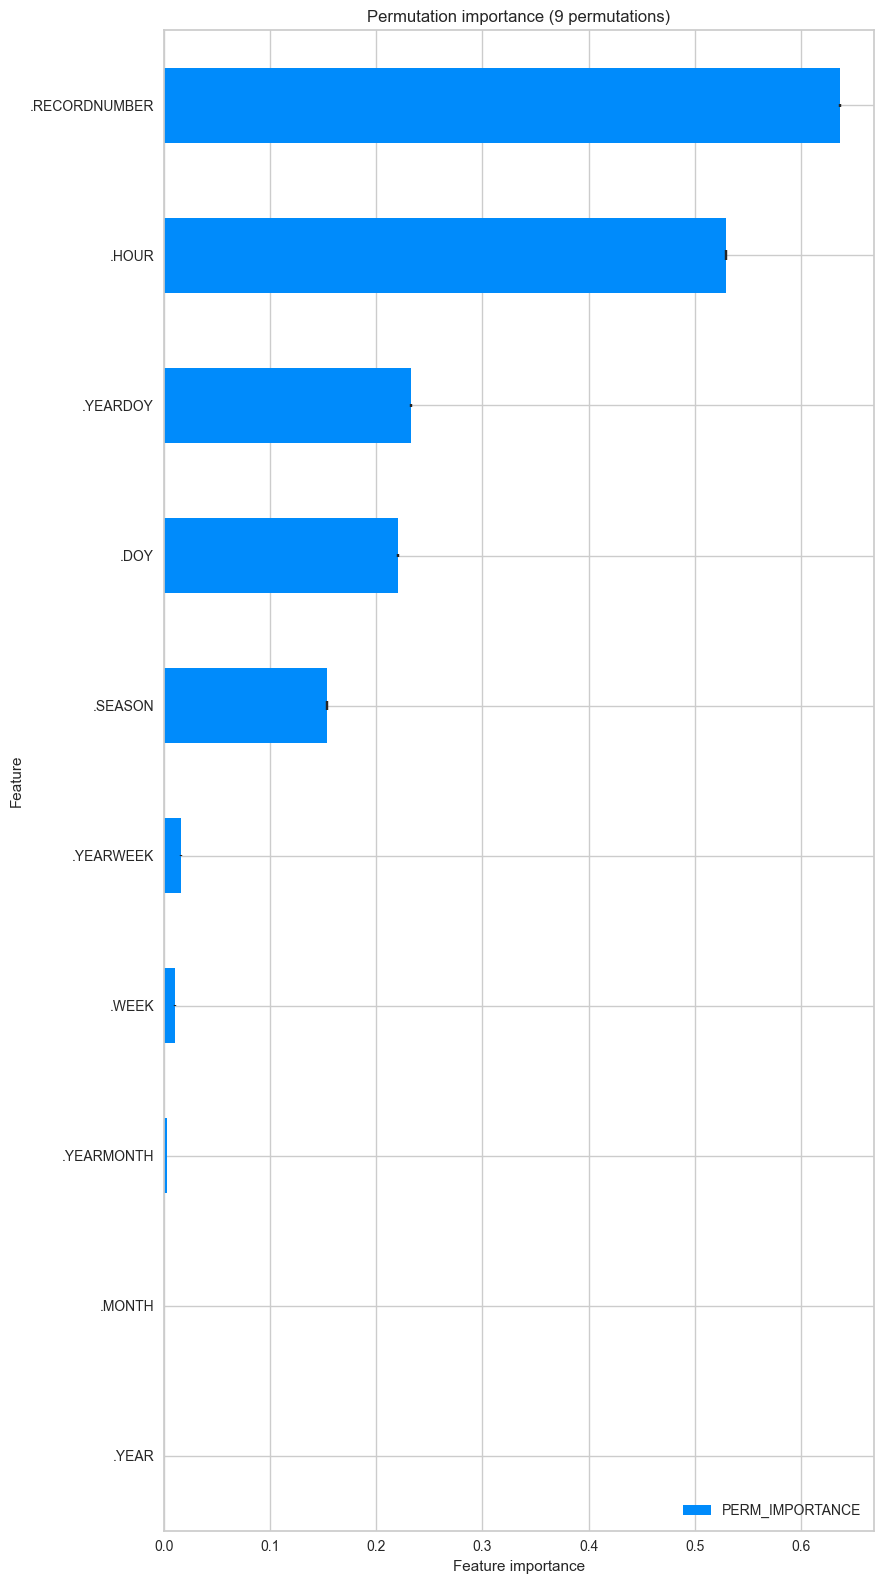

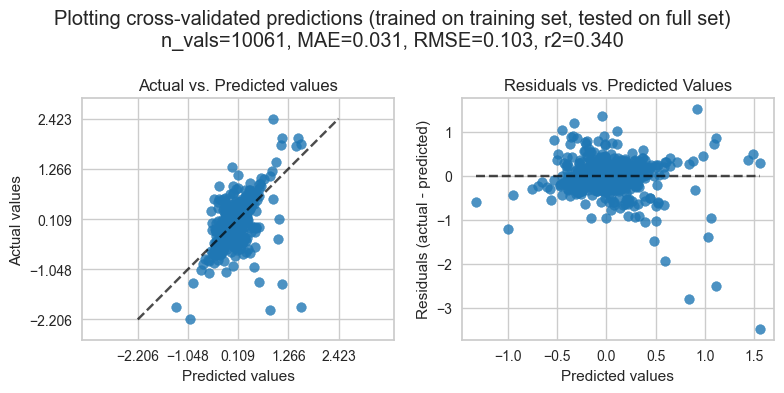


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (7459 values, SN2O_SINGLE_gfRF where flag=1) in comparison to observed targets (10061 values, SN2O_SINGLE).

## TARGET
- first timestamp:  2019-01-01 01:15:00
- last timestamp:  2020-01-01 00:45:00
- potential number of values: 17520 values)
- target column (observed):  SN2O_SINGLE
- missing records (observed):  7459 (cross-check from flag: 7459)
- target column (gap-filled):  SN2O_SINGLE_gfRF  (17520 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_SN2O_SINGLE_gfRF_ISFILLED
  > flag 0 ... observed targets (10061 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (7459 values)
  > flag 2 ... targets gap-filled with fallback (0 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['.RECORDNUMBER', '.HOUR', '.YEARDOY', '.DOY', '.SEASON', '.YEARWEEK', '.WEEK', '.YEARMONTH', '.MONTH', '.YEAR']
- number of features 

In [22]:
s.storage_correction()

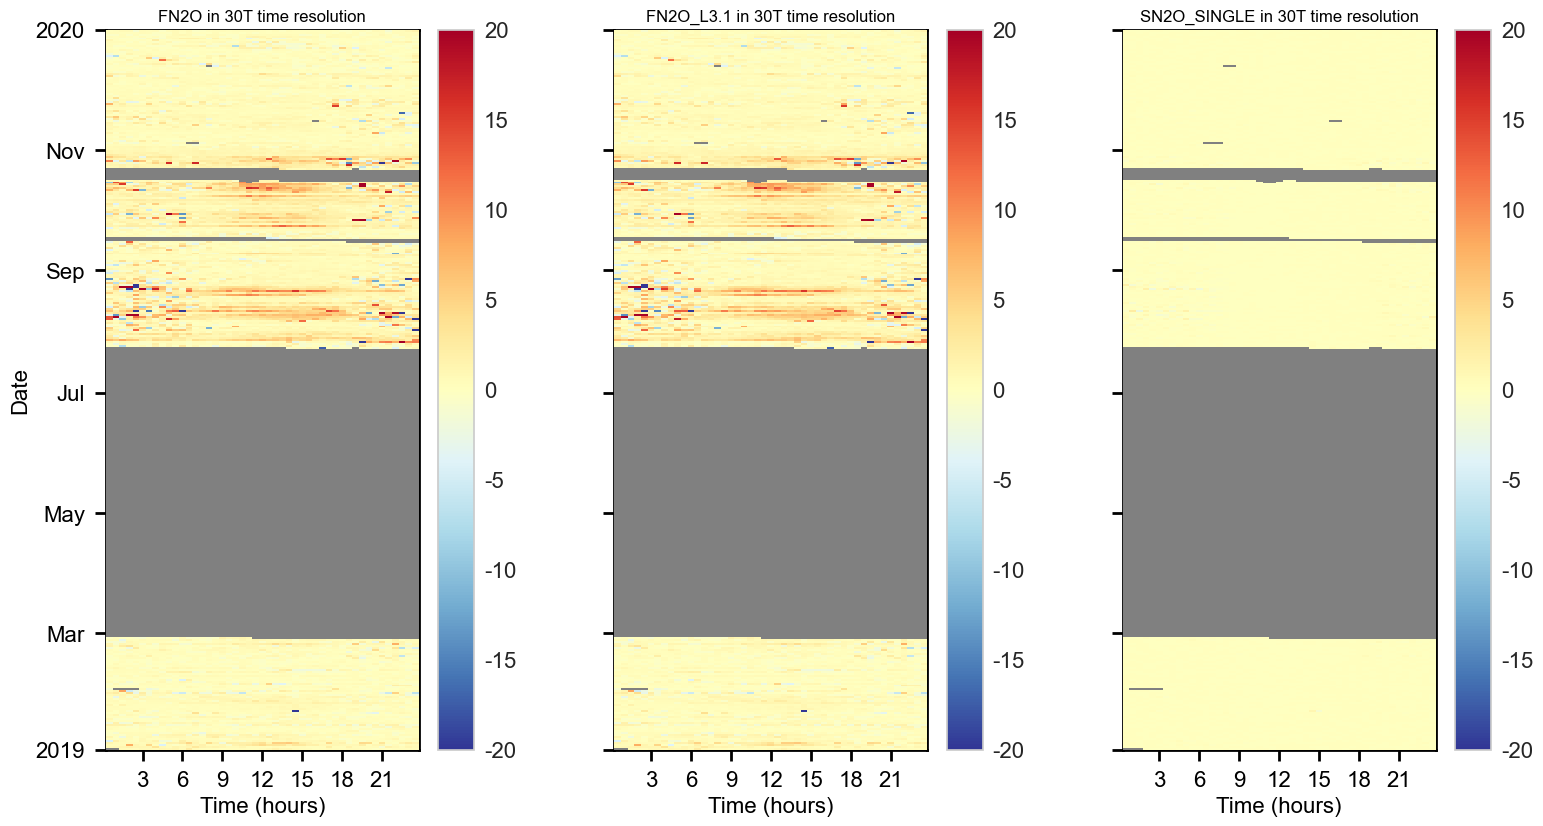

In [23]:
s.showplot(maxflux=20)

In [24]:
s.report()


REPORT: STORAGE CORRECTION FOR FN2O
Swiss FluxNet processing chain, L3.1: Storage Correction

The gap-filled storage term SN2O_SINGLE_gfRF_L3.1 was added to flux FN2O.
The storage-corrected flux was stored as FN2O_L3.1.

The flux was available for 10073 records (FN2O).
Originally, the non-gapfilled storage term was available for 10061 records (SN2O_SINGLE).
This means that the storage term SN2O_SINGLE was missing for 12 measured flux (FN2O) records.
After gap-filling the storage term, it was available for an additional 12 records (SN2O_SINGLE_gfRF_L3.1).

In the storage-corrected flux FN2O_L3.1 with 10073 records, 
  - 99.9% (10061 records) of used storage terms come from originally calculated data (SN2O_SINGLE)
  - 0.1% (12 records) of used storage terms come from gap-filled data (SN2O_SINGLE_gfRF_L3.1)

Stats for gap-filled storage terms:
                      NOV      P01    MEDIAN       P99
SN2O_SINGLE_gfRF_L3.1  12 -0.08218 -0.001298  0.098918

Stats for measured storage terms:
 

</br>

## Add results to dataset
- Adds the storage-corrected flux and the gap-filled storage term time series to the dataset

In [25]:
# print(s.storage)
df_level31 = s.get()

++Adding new column FN2O_L3.1 to main data ...
++Adding new column SN2O_SINGLE_gfRF_L3.1 to main data ...


In [26]:
df_level31

AIR_MV  AIR_DENSITY  AIR_RHO_CP  AOA_METHOD  AXES_ROTATION_METHOD     BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_MODEL_SA  BADM_INST_HEIGHT_SA  ...  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED        ZL  ZL_UNCORR  FLAG_L2_FN2O_MISSING_TEST  FLAG_L2_FN2O_SSITC_TEST  FLAG_L2_FN2O_COMPLETENESS_TEST  FLAG_L2_FN2O_SCF_TEST  FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST  FLAG_L2_FN2O_N2O_VM97_AMPLITUDE_RESOLUTION_HF_TEST  FLAG_L2_FN2O_N2O_VM97_DROPOUT_TEST  FLAG_L2_FN2O_VM97_AOA_HF_TEST  FN2O_L3.1  SN2O_SINGLE_gfRF_L3.1
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                     ...                                                                                                                                                                                                                                                                                                                                                                       
2019-01-01 01:15:00  0.023615      1.22252     1234.70         0.0                   1.0   2.62615           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...         3.0             0.0          0.0  0.030711   0.031205                        0.0                      NaN                             0.0                    0.0                                  0.0                                                0.0                                  0.0                            0.0   0.631518               0.001508
2019-01-01 01:45:00  0.023617      1.22240     1234.57         0.0                   1.0  -1.17256           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...         2.0             0.0          0.0  0.018084   0.017335                        0.0                      NaN                             0.0                    0.0                                  0.0                                                0.0                                  0.0                            0.0   0.584300               0.007256
2019-01-01 02:15:00  0.023607      1.22296     1235.09         0.0                   1.0   1.65116           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...         2.0             0.0          0.0  0.025143   0.025785                        0.0                      NaN                             0.0                    0.0                                  0.0                                                0.0                                  0.0                            0.0   0.605795              -0.009035
2019-01-01 02:45:00  0.023594      1.22368     1235.75         0.0                   1.0   3.91349           0.0            47.2864             7.73375               452.0         0.063                    20.0                     30.0                 NaN                 2.17  ...         2.0             0.0          0.0  0.035294   0.035602                        0.0                      NaN                             0.0                    0.0                                  0.0                                                0.0                                  0.0                            0.0   0.921723              -0.009807
2019-01-01 03:15:00  0.023589      1.22395     1235.96         0.0                   1.0  -4.53499           0.0            47.2864             7.73375               452.0         0.0

</br>

## Available `Level-3.1` variables before preliminary QCF

In [27]:
_vars = [print(x) for x in df_level31.columns if 'L3.1' in x]
if FLUXVAR == 'FC':
    FLUXVAR31 = f"NEE_L3.1"
else:
    FLUXVAR31 = f"{FLUXVAR}_L3.1"  # Storage-corrected flux after Level-3.1
print(f"\nName of the storage-corrected flux variable after Level-3.1:  {FLUXVAR31}")

FN2O_L3.1
SN2O_SINGLE_gfRF_L3.1

Name of the storage-corrected flux variable after Level-3.1:  FN2O_L3.1


</br>

## Generate `QCF`, needed for Level-3.2
- `QCF` is the `quality control flag` that combines the quality tests so far into one single `QCF` flag (0-1-2)

In [28]:
qcf = FlagQCF(series=df_level31[FLUXVAR31], df=df_level31, levelid='L3.1', swinpot=df_level31['SW_IN_POT'], nighttime_threshold=50)
qcf.calculate(daytime_accept_qcf_below=2, nighttimetime_accept_qcf_below=2)
df_level31 = qcf.get()

++Adding new column SUM_L3.1_FN2O_L3.1_HARDFLAGS to main data ...
++Adding new column SUM_L3.1_FN2O_L3.1_SOFTFLAGS to main data ...
++Adding new column SUM_L3.1_FN2O_L3.1_FLAGS to main data ...
++Adding new column FLAG_L3.1_FN2O_L3.1_QCF to main data ...
++Adding new column FN2O_L3.1_L3.1_QCF to main data ...


In [29]:
qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FN2O_L3.1.

Number of FN2O_L3.1 records before QC: 10073
+++ FLAG_L2_FN2O_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 10073 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FN2O_SSITC_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 10073 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FN2O_COMPLETENESS_TEST rejected 18 values (+0.18%)      TOTALS: flag 0: 10054 (99.81%) / flag 1: 1 (0.01%) / flag 2: 18 (0.18%)
+++ FLAG_L2_FN2O_SCF_TEST rejected 15 values (+0.15%)      TOTALS: flag 0: 9245 (91.78%) / flag 1: 795 (7.89%) / flag 2: 33 (0.33%)
+++ FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9245 (91.78%) / flag 1: 795 (7.89%) / flag 2: 33 (0.33%)
+++ FLAG_L2_FN2O_N2O_VM97_AMPLITUDE_RESOLUTION_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9245 (91.78%) /

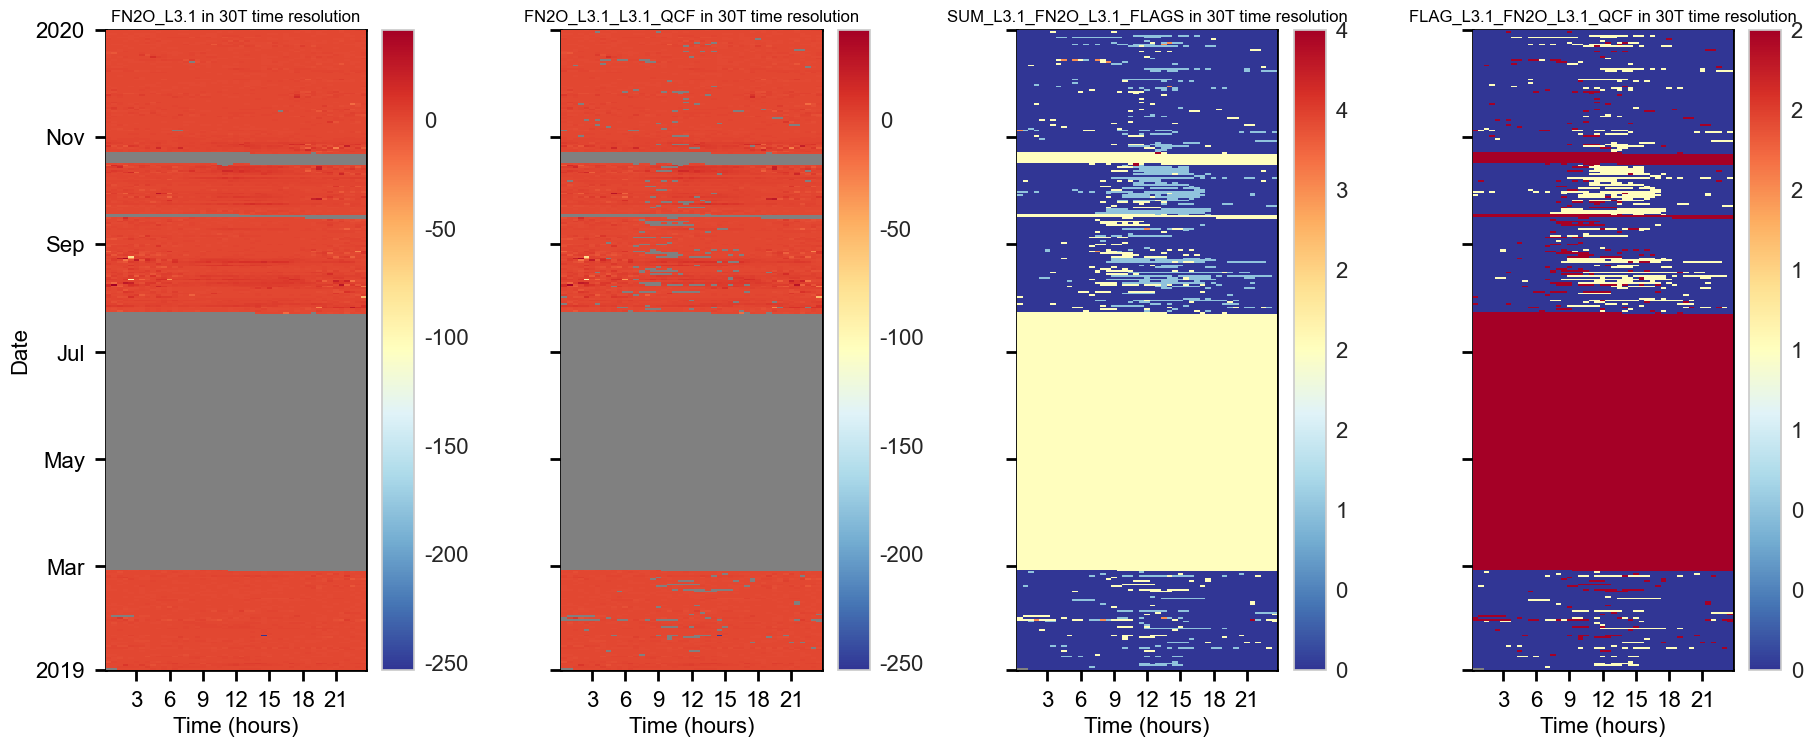

In [30]:
qcf.showplot_qcf_heatmaps()

In [31]:
qcf.report_qcf_series()



SUMMARY: FLAG_L3.1_FN2O_L3.1_QCF, QCF FLAG FOR FN2O_L3.1
Between 2019-01-01 01:15 and 2020-01-01 00:45 ...
    Total flux records BEFORE quality checks: 10073 (57.49% of potential)
    Available flux records AFTER quality checks: 9716 (96.46% of total)
    Rejected flux records: 357 (3.54% of total)
    Potential flux records: 17520
    Potential flux records missed: 7447 (42.51% of potential)



In [ ]:
qcf.report_qcf_flags()

In [ ]:
qcf.showplot_qcf_timeseries()

## Available `Level-3.1` variables after preliminary QCF
- This shows all available Level-3.1 variables, also the ones created previously for other fluxes

In [32]:
_vars = [print(x) for x in df_level31.columns if 'L3.1' in x]
FLUXVAR31QCF = f"{FLUXVAR31}_L3.1_QCF"  # Quality-controlled flux after Level-3.1
print(f"\nName of the storage-corrected and quality-controlled flux variable after Level-3.1:  {FLUXVAR31QCF}  (this variable will be used in the following outlier detection)")

FN2O_L3.1
SN2O_SINGLE_gfRF_L3.1
SUM_L3.1_FN2O_L3.1_HARDFLAGS
SUM_L3.1_FN2O_L3.1_SOFTFLAGS
SUM_L3.1_FN2O_L3.1_FLAGS
FLAG_L3.1_FN2O_L3.1_QCF
FN2O_L3.1_L3.1_QCF

Name of the storage-corrected and quality-controlled flux variable after Level-3.1:  FN2O_L3.1_L3.1_QCF  (this variable will be used in the following outlier detection)


</br>

</br>

# **Level-3.2: Outlier detection**
- Needs quality-controlled data (so far)

</br>

## Plot time series

In [33]:
print(f"{FLUXVAR31QCF} \n(quality-controlled Level-3.1 version of {FLUXVAR31}) \n(originally based on {FLUXVAR})")

FN2O_L3.1_L3.1_QCF 
(quality-controlled Level-3.1 version of FN2O_L3.1) 
(originally based on FN2O)


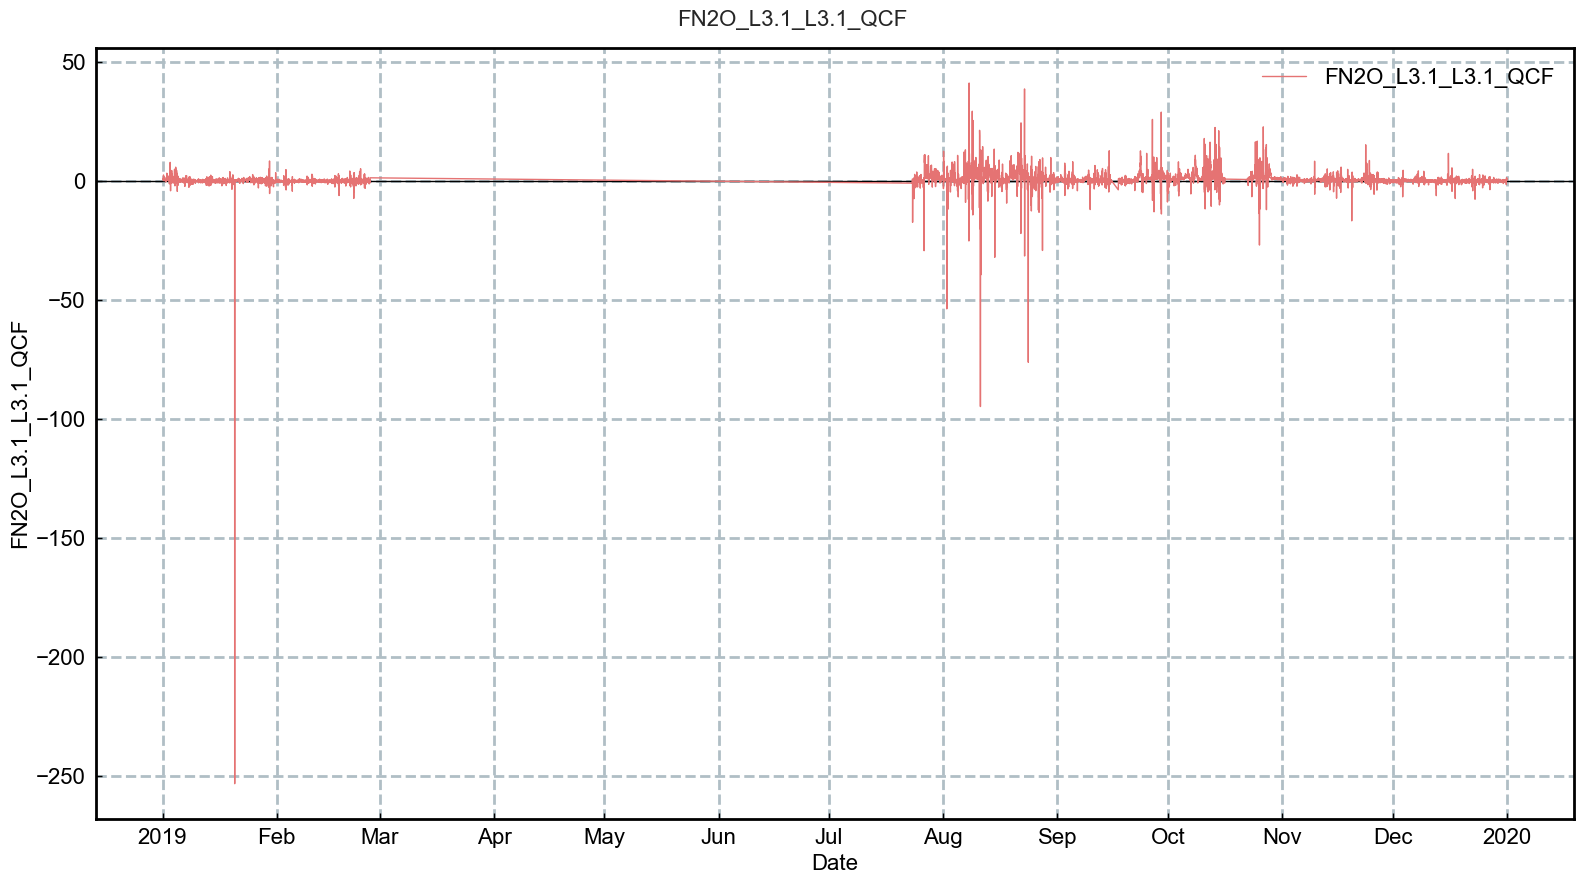

In [34]:
# TimeSeries(series=df_level31[FLUXVAR31QCF]).plot_interactive()
TimeSeries(series=df_level31[FLUXVAR31QCF]).plot()

</br>

## Initiate calculations

In [35]:
sod = StepwiseOutlierDetection(dataframe=df_level31,
                               col=FLUXVAR31QCF,
                               site_lat=SITE_LAT,
                               site_lon=SITE_LON,
                               timezone_of_timestamp='UTC+01:00')

</br>

</br>

## Flag, outlier detection: **absolute limits, separate for daytime and nighttime data**

Identify outliers based on absolute limits separately for daytime and nighttime


[AbsoluteLimitsDaytimeNighttime]  ========================================
[AbsoluteLimitsDaytimeNighttime]  AbsoluteLimitsDaytimeNighttime
[AbsoluteLimitsDaytimeNighttime]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST for variable FN2O_L3.1_L3.1_QCF ...
Calculating sun altitude in 30T time resolution ...
Generating nighttime flag (1=nighttime, 0=daytime) from sun altitude ...
[AbsoluteLimitsDaytimeNighttime]  Done.
[AbsoluteLimitsDaytimeNighttime]  ________________________________________


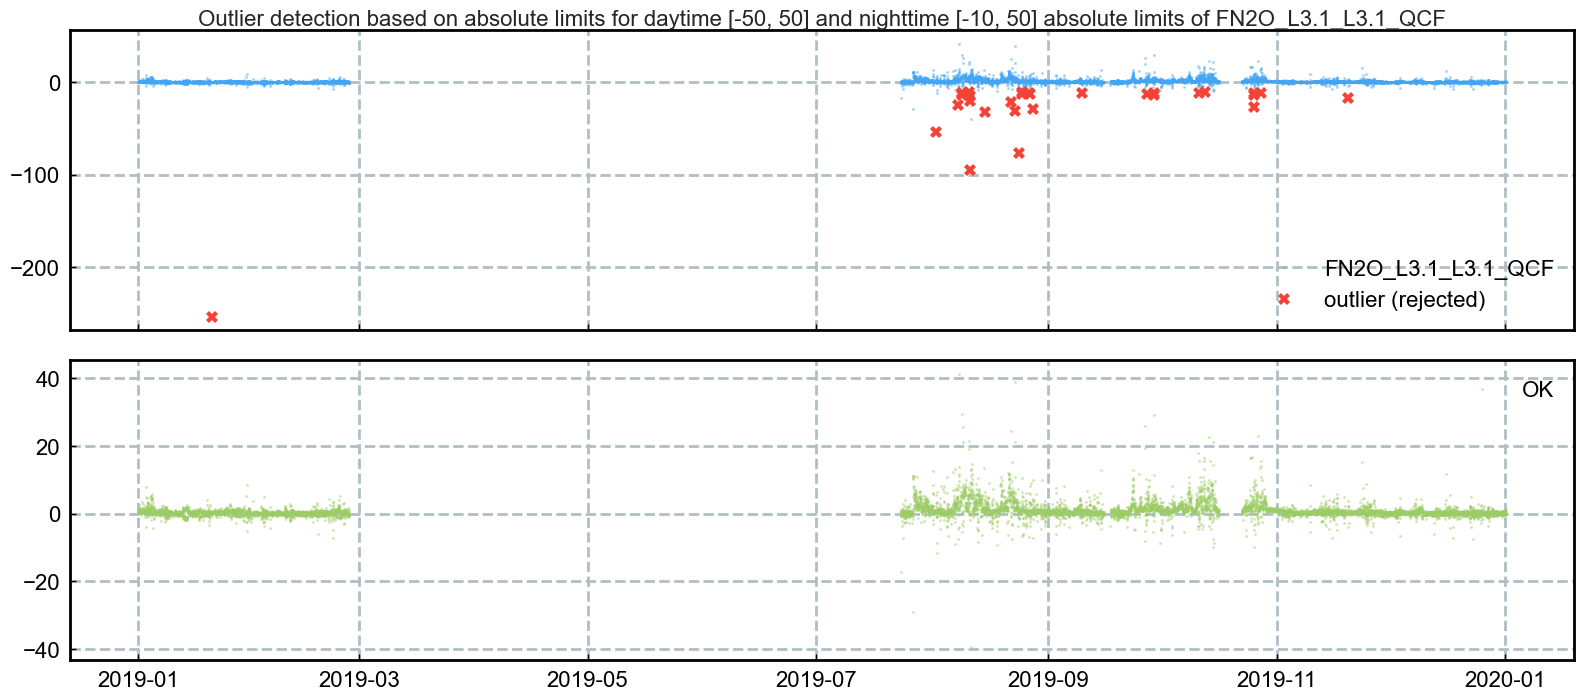

In [36]:
MIN_DT = -50
MAX_DT = 50
MIN_NT = -10
MAX_NT = 50
print(sod.flag_outliers_abslim_dtnt_test.__doc__)
sod.flag_outliers_abslim_dtnt_test(daytime_minmax=[MIN_DT, MAX_DT], nighttime_minmax=[MIN_NT, MAX_NT], showplot=True, verbose=True)

In [37]:
sod.addflag()

++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST to flag data


</br>

</br>

## Flag, outlier detection: **Absolute limits**

Identify outliers based on absolute limits


[AbsoluteLimits]  ========================================
[AbsoluteLimits]  AbsoluteLimits
[AbsoluteLimits]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ABSLIM_TEST for variable FN2O_L3.1_L3.1_QCF ...
[AbsoluteLimits]  Done.
[AbsoluteLimits]  ________________________________________


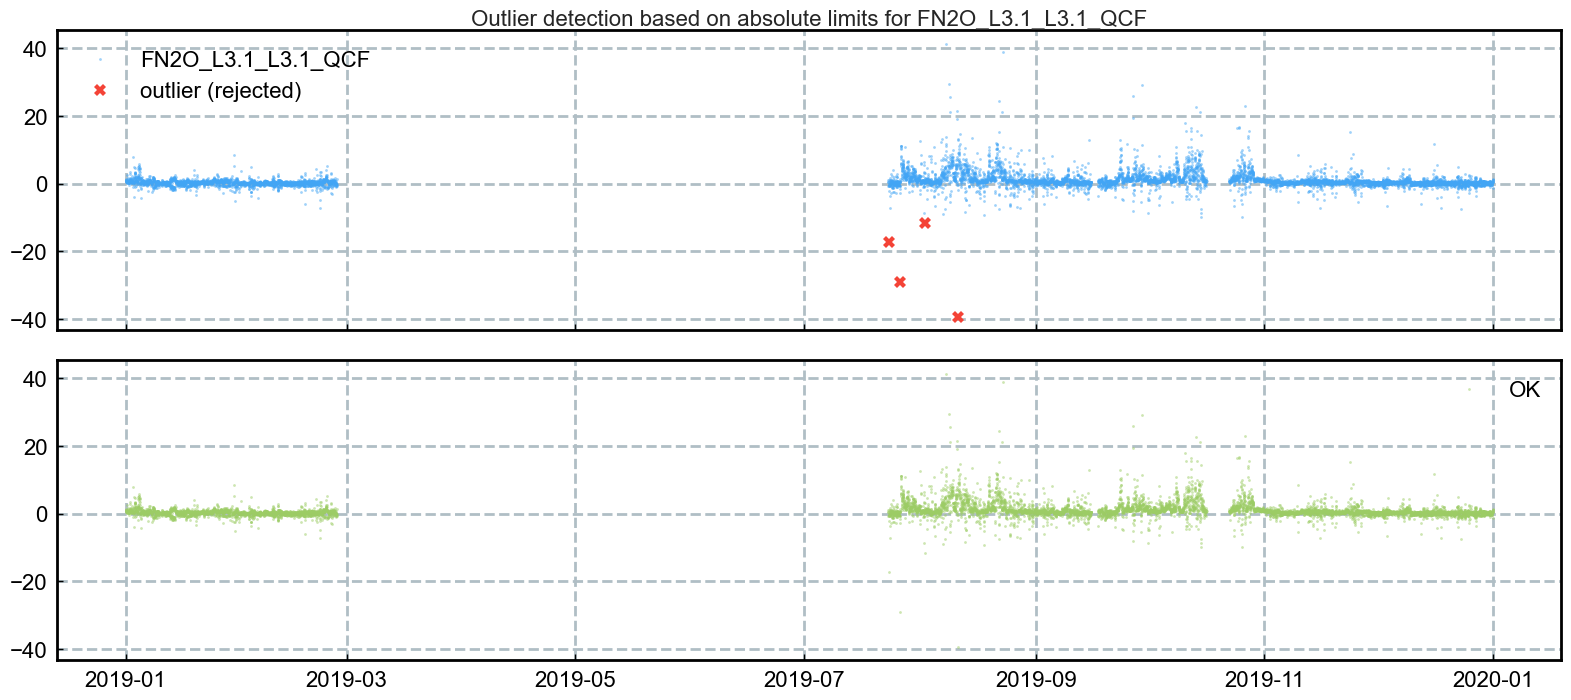

In [38]:
MIN = -10
MAX = 50
print(sod.flag_outliers_abslim_test.__doc__)
sod.flag_outliers_abslim_test(minval=MIN, maxval=MAX, showplot=True, verbose=True)

In [39]:
sod.addflag()

++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ABSLIM_TEST to flag data


</br>

</br>

## Flag, outlier detection: **z-score over all data, separate for daytime and nighttime**

Flag outliers based on z-score, calculated separately for daytime and nighttime


[zScoreDaytimeNighttime]  ========================================
[zScoreDaytimeNighttime]  zScoreDaytimeNighttime
[zScoreDaytimeNighttime]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST for variable FN2O_L3.1_L3.1_QCF ...
Calculating sun altitude in 30T time resolution ...
Generating nighttime flag (1=nighttime, 0=daytime) from sun altitude ...
[zScoreDaytimeNighttime]  Done.
[zScoreDaytimeNighttime]  ________________________________________
Total found outliers: 0 values (daytime)
Total found outliers: 14 values (nighttime)
Total found outliers: 14 values (daytime+nighttime)


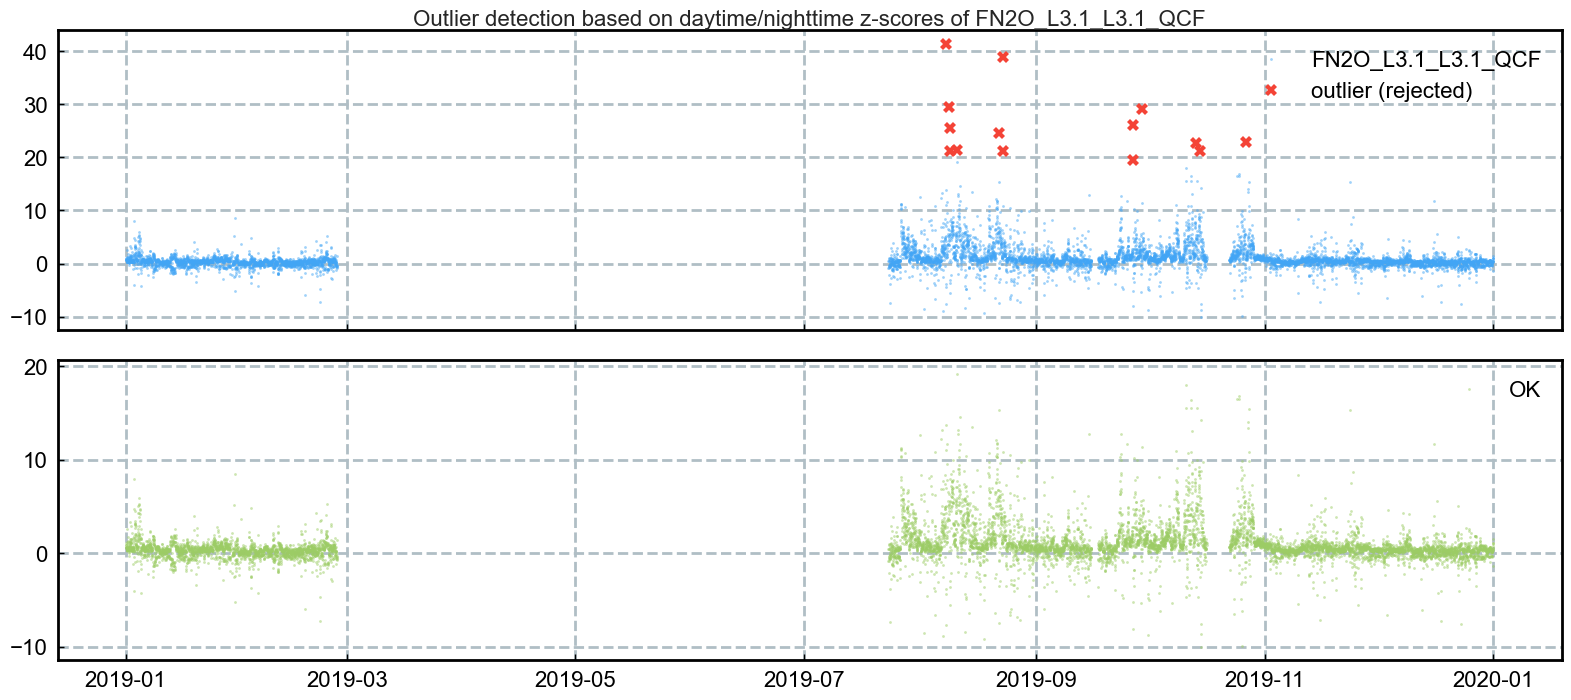

In [41]:
print(sod.flag_outliers_zscore_dtnt_test.__doc__)
sod.flag_outliers_zscore_dtnt_test(threshold=8, showplot=True, verbose=True)

In [42]:
sod.addflag()

++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST to flag data


</br>

</br>

## Flag, oulier detection: **Local standard deviation**

Identify outliers based on standard deviation in a rolling window


[LocalSD]  ========================================
[LocalSD]  LocalSD
[LocalSD]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOCALSD_TEST for variable FN2O_L3.1_L3.1_QCF ...
[LocalSD]  Done.
[LocalSD]  ________________________________________


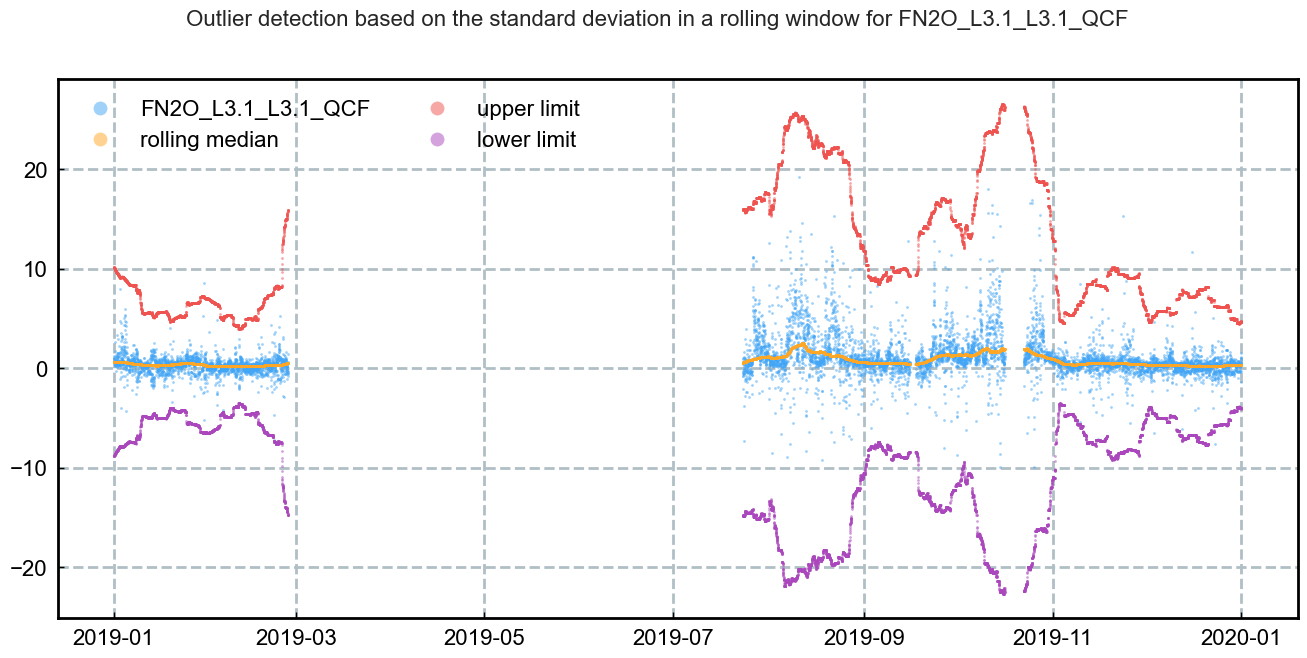

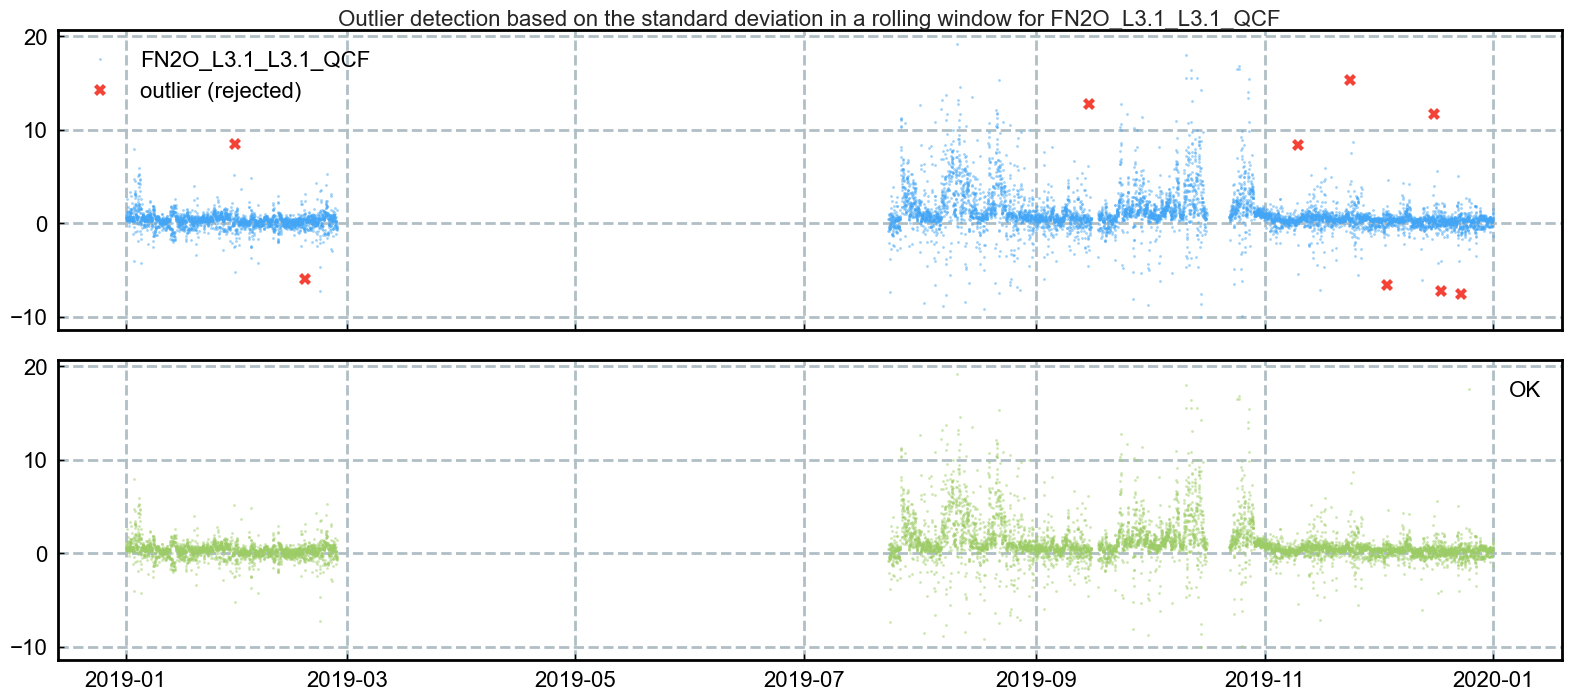

In [43]:
print(sod.flag_outliers_localsd_test.__doc__)
sod.flag_outliers_localsd_test(n_sd=7, winsize=480, showplot=True, verbose=True)

In [44]:
sod.addflag()

++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOCALSD_TEST to flag data


</br>

</br>

## Flag, outlier detection: **Manual flagging of datapoints**

In [ ]:
# sod.showplot_cleaned(interactive=True)
sod.showplot_cleaned(interactive=False)

In [ ]:
print(sod.flag_manualremoval_test.__doc__)
sod.flag_manualremoval_test(remove_dates=[['2022-03-05 19:45:00', '2022-04-05 19:45:00']],
                            showplot=True, verbose=True)

In [ ]:
sod.addflag()

In [ ]:
# sod.showplot_cleaned(interactive=True)
sod.showplot_cleaned(interactive=False)

</br>

</br>

## Flag, outlier detection: **Increments z-score**

Identify outliers based on the z-score of record increments


[zScoreIncrements]  ========================================
[zScoreIncrements]  zScoreIncrements
[zScoreIncrements]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_INCRZ_TEST for variable FN2O_L3.1_L3.1_QCF ...
[zScoreIncrements]  Done.
[zScoreIncrements]  ________________________________________


[zScore]  ========================================
[zScore]  zScore
[zScore]  ========================================
Generating flag FLAG_INCREMENT_OUTLIER_ZSCORE_TEST for variable INCREMENT ...
[zScore]  Done.
[zScore]  ________________________________________
Total found outliers: 10 values
Total found outliers: 10 values (daytime+nighttime)


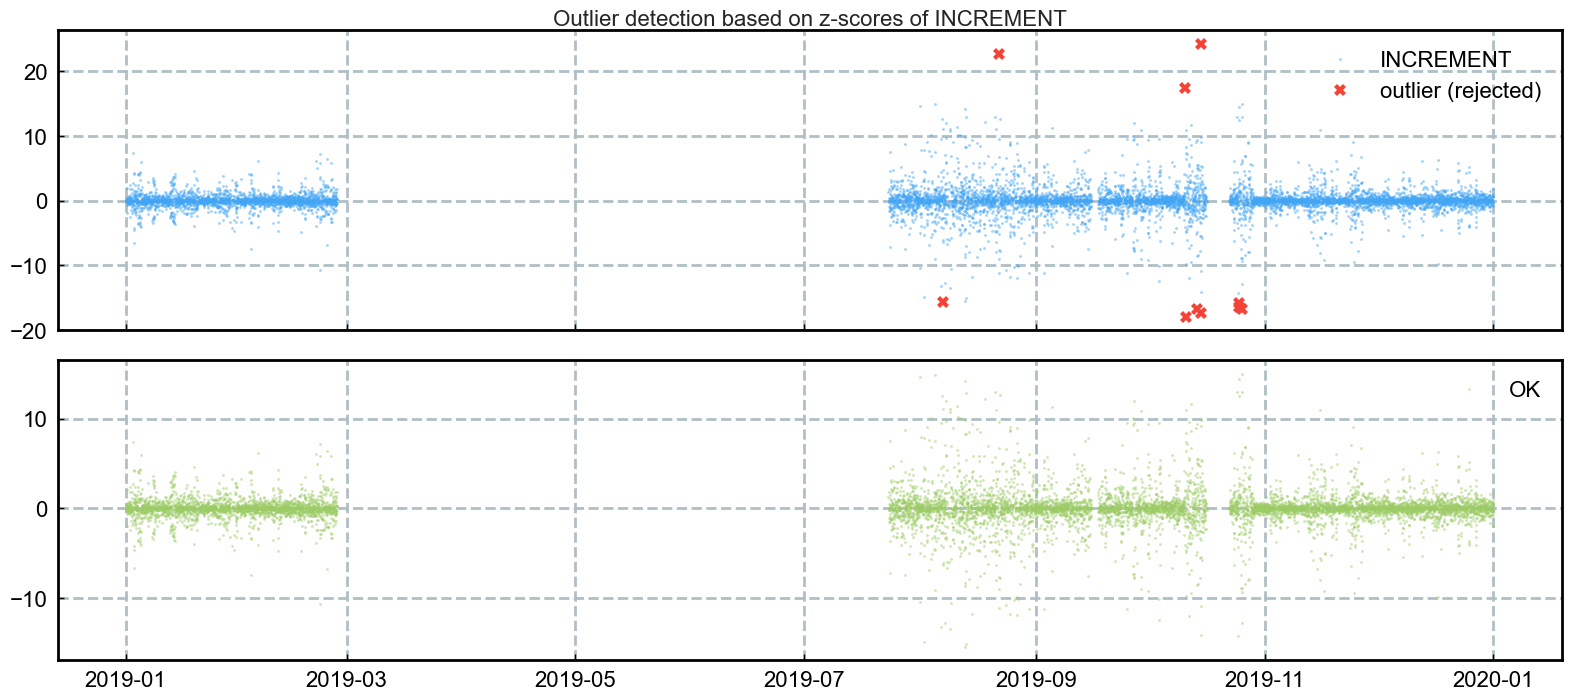

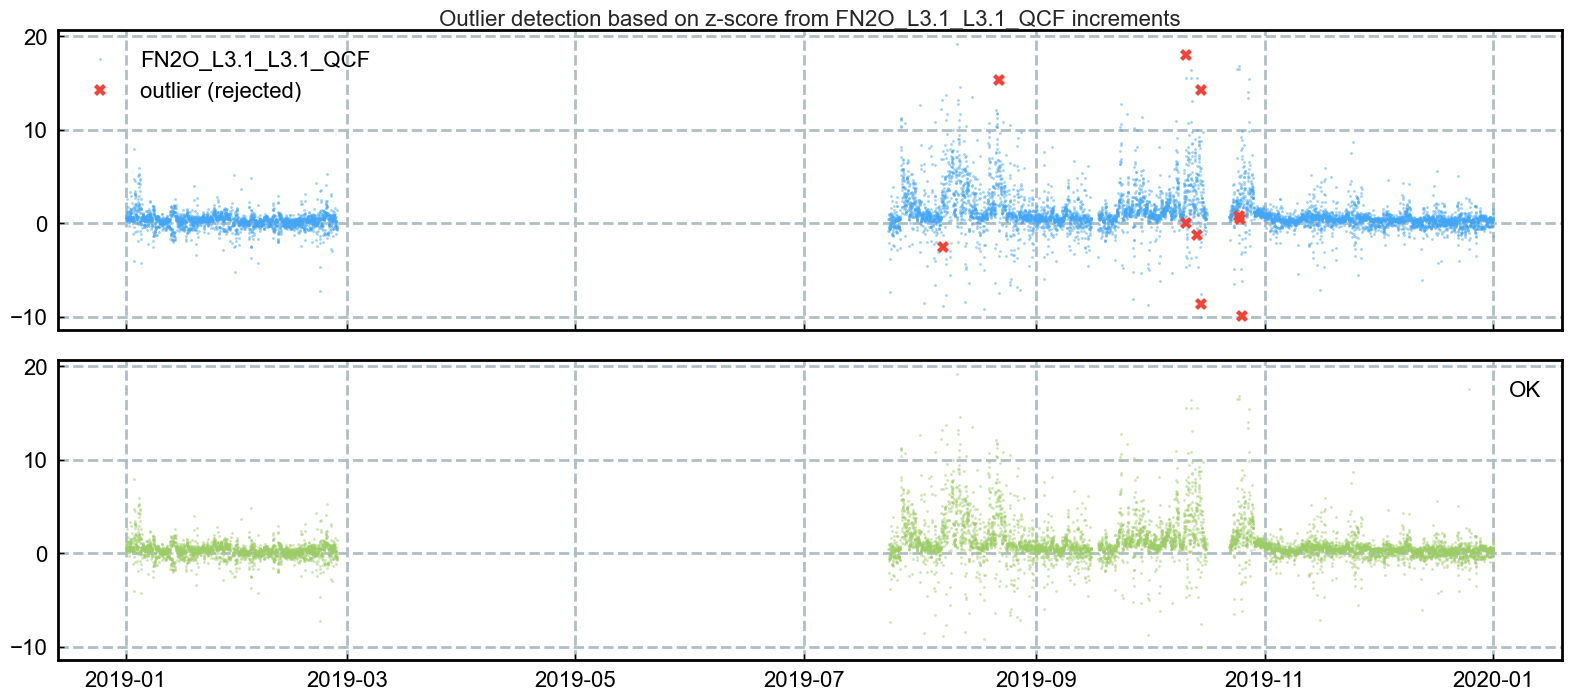

In [45]:
print(sod.flag_outliers_increments_zcore_test.__doc__)
sod.flag_outliers_increments_zcore_test(threshold=8, showplot=True, verbose=True)

In [46]:
sod.addflag()

++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_INCRZ_TEST to flag data


</br>

</br>

## Flag, outlier detection: **z-score over all data**

Identify outliers based on the z-score of records


[zScore]  ========================================
[zScore]  zScore
[zScore]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ZSCORE_TEST for variable FN2O_L3.1_L3.1_QCF ...
[zScore]  Done.
[zScore]  ________________________________________
Total found outliers: 10 values


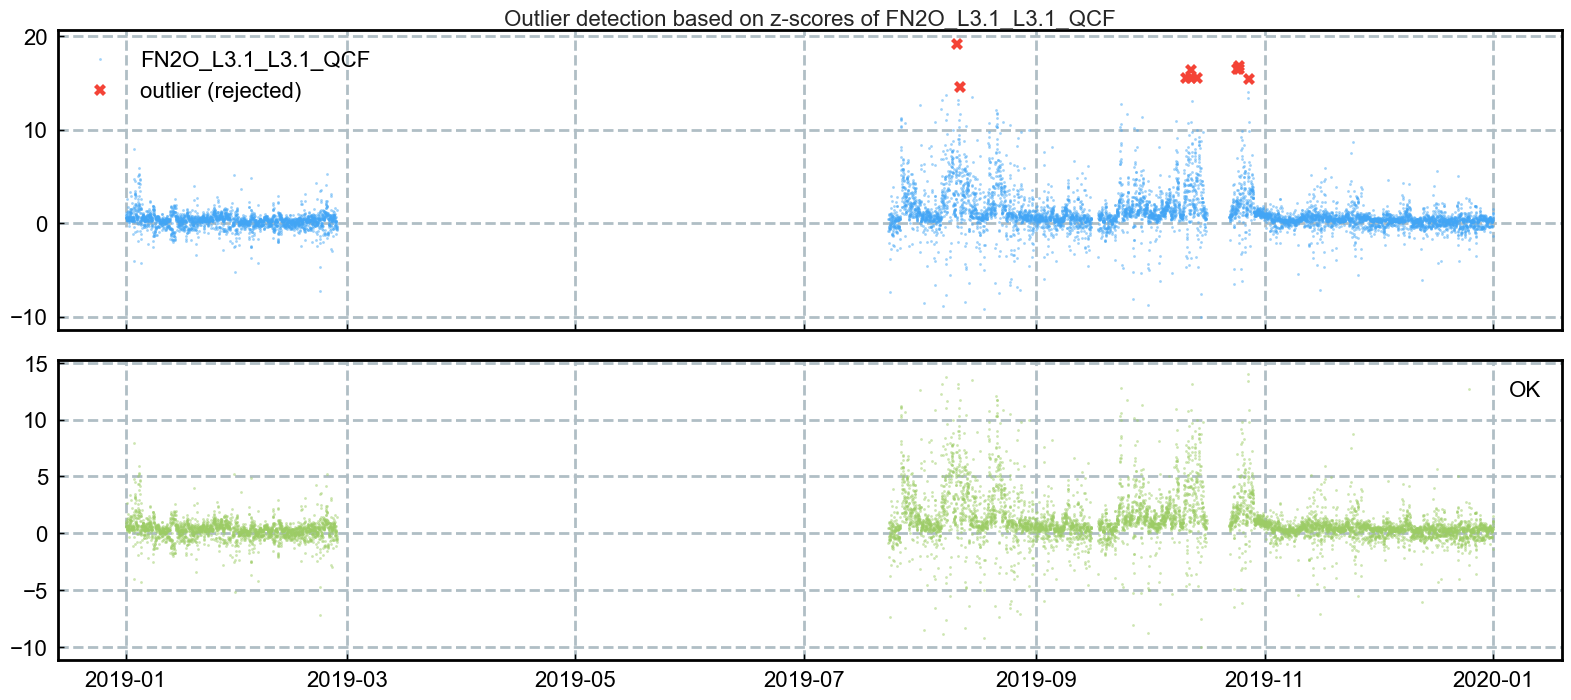

In [47]:
print(sod.flag_outliers_zscore_test.__doc__)
sod.flag_outliers_zscore_test(threshold=7, showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **Seasonal trend decomposition with z-score on residuals**

Identify outliers based on seasonal-trend decomposition and z-score calculations


[OutlierSTLRZ]  ========================================
[OutlierSTLRZ]  OutlierSTLRZ
[OutlierSTLRZ]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_STLRZ_TEST for variable FN2O_L3.1_L3.1_QCF ...
Calculating sun altitude in 30T time resolution ...
Generating nighttime flag (1=nighttime, 0=daytime) from sun altitude ...
[OutlierSTLRZ]  Done.
[OutlierSTLRZ]  ________________________________________

Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Adding continuous record number ...
Added new column .RECORDNUMBER with record numbers from 1 to 17520.

Sanitizing timestamp ...
Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
Sorting timestamp TIMESTAMP_MIDDLE a

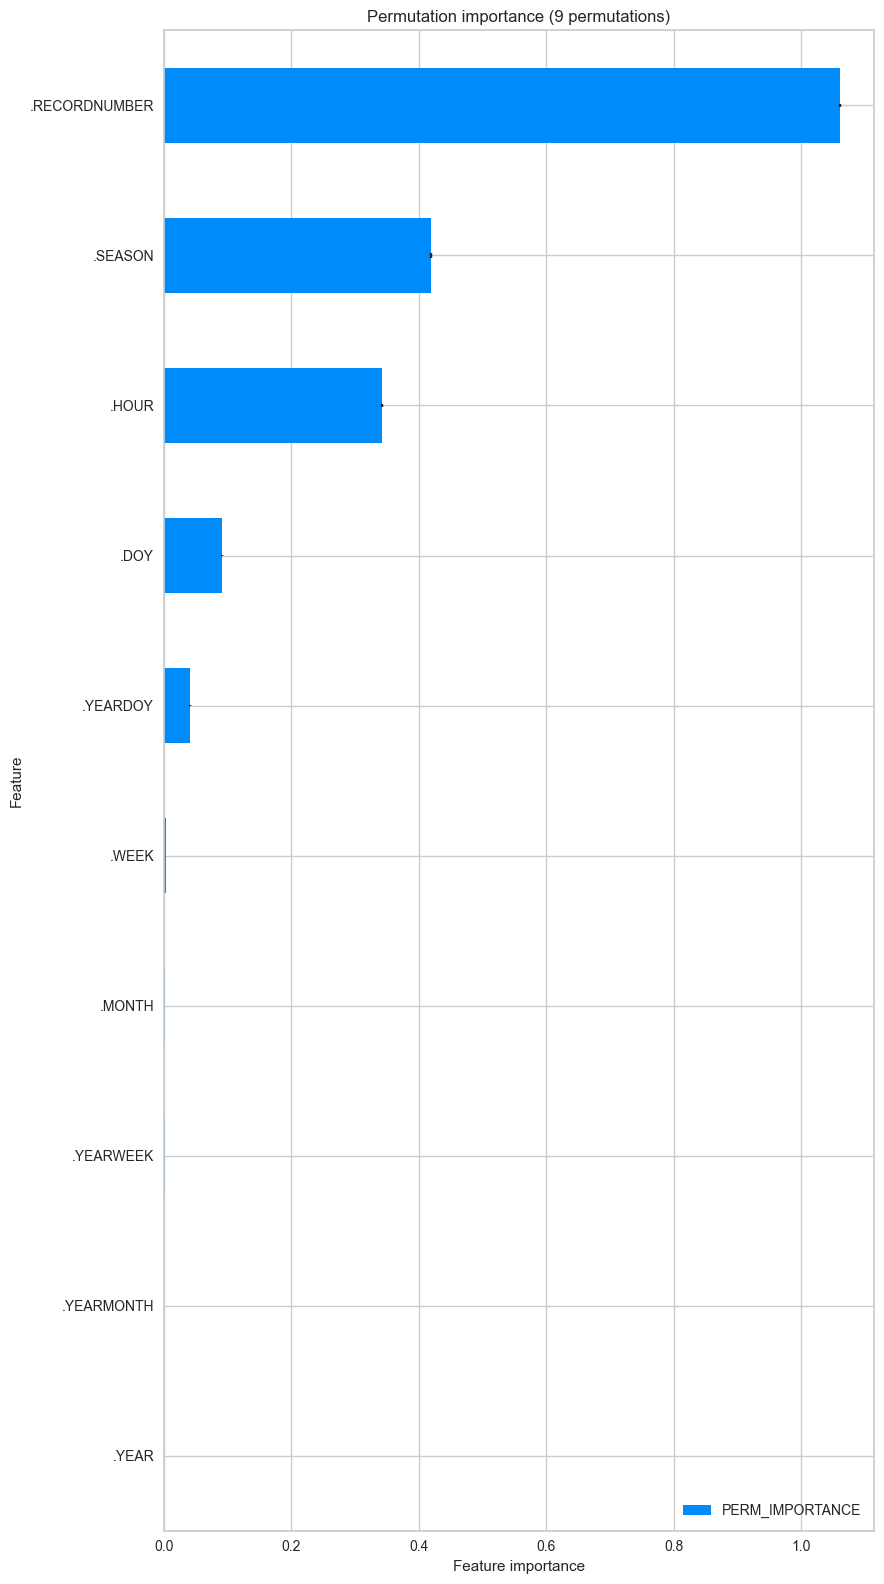

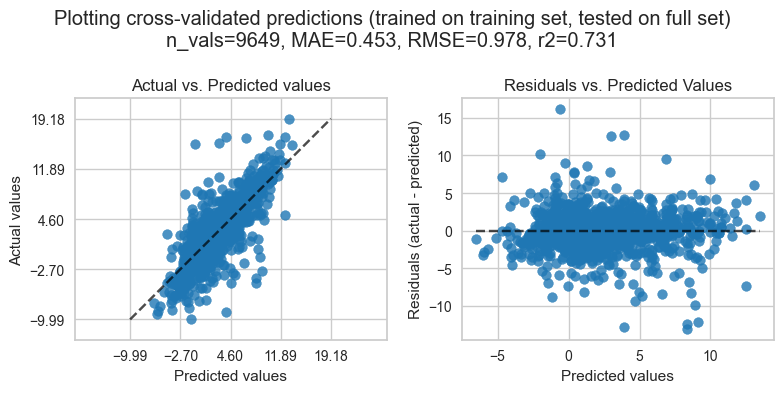

Decomposing timeseries ...


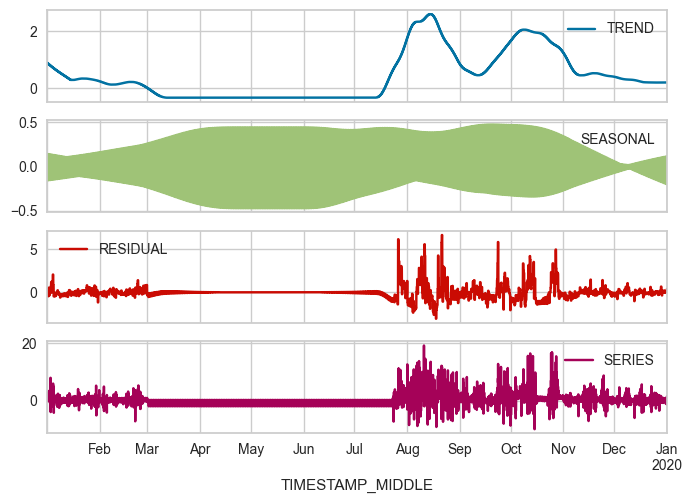

Detecting residual outliers ...


[zScoreDaytimeNighttime]  ========================================
[zScoreDaytimeNighttime]  zScoreDaytimeNighttime
[zScoreDaytimeNighttime]  ========================================
Generating flag FLAG_RESIDUAL_OUTLIER_ZSCOREDTNT_TEST for variable RESIDUAL ...
Calculating sun altitude in 30T time resolution ...
Generating nighttime flag (1=nighttime, 0=daytime) from sun altitude ...
[zScoreDaytimeNighttime]  Done.
[zScoreDaytimeNighttime]  ________________________________________
Total found outliers: 203 values (daytime)
Total found outliers: 199 values (nighttime)
Total found outliers: 402 values (daytime+nighttime)
New outliers: 368


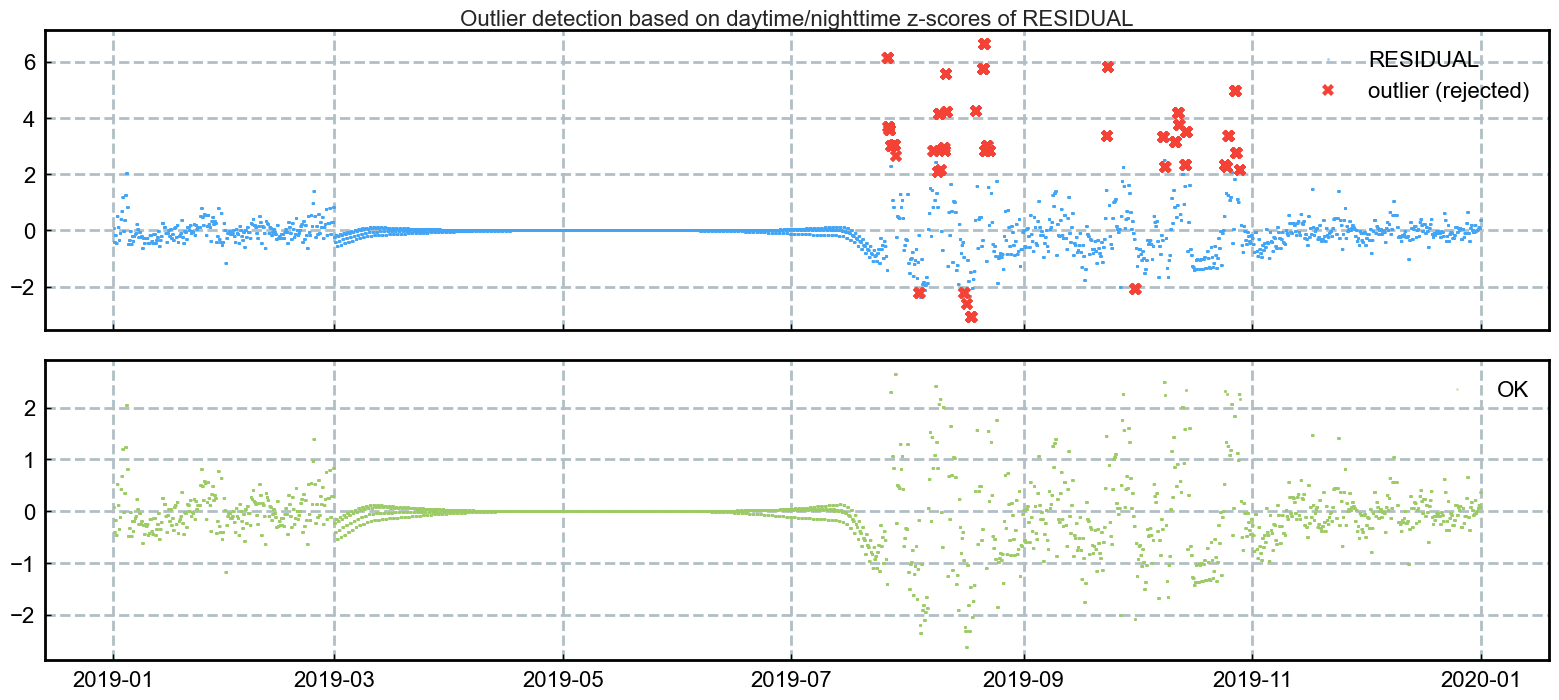

In [48]:
print(sod.flag_outliers_stl_rz_test.__doc__)
sod.flag_outliers_stl_rz_test(zfactor=3, decompose_downsampling_freq='6H', repeat=False, showplot=True)

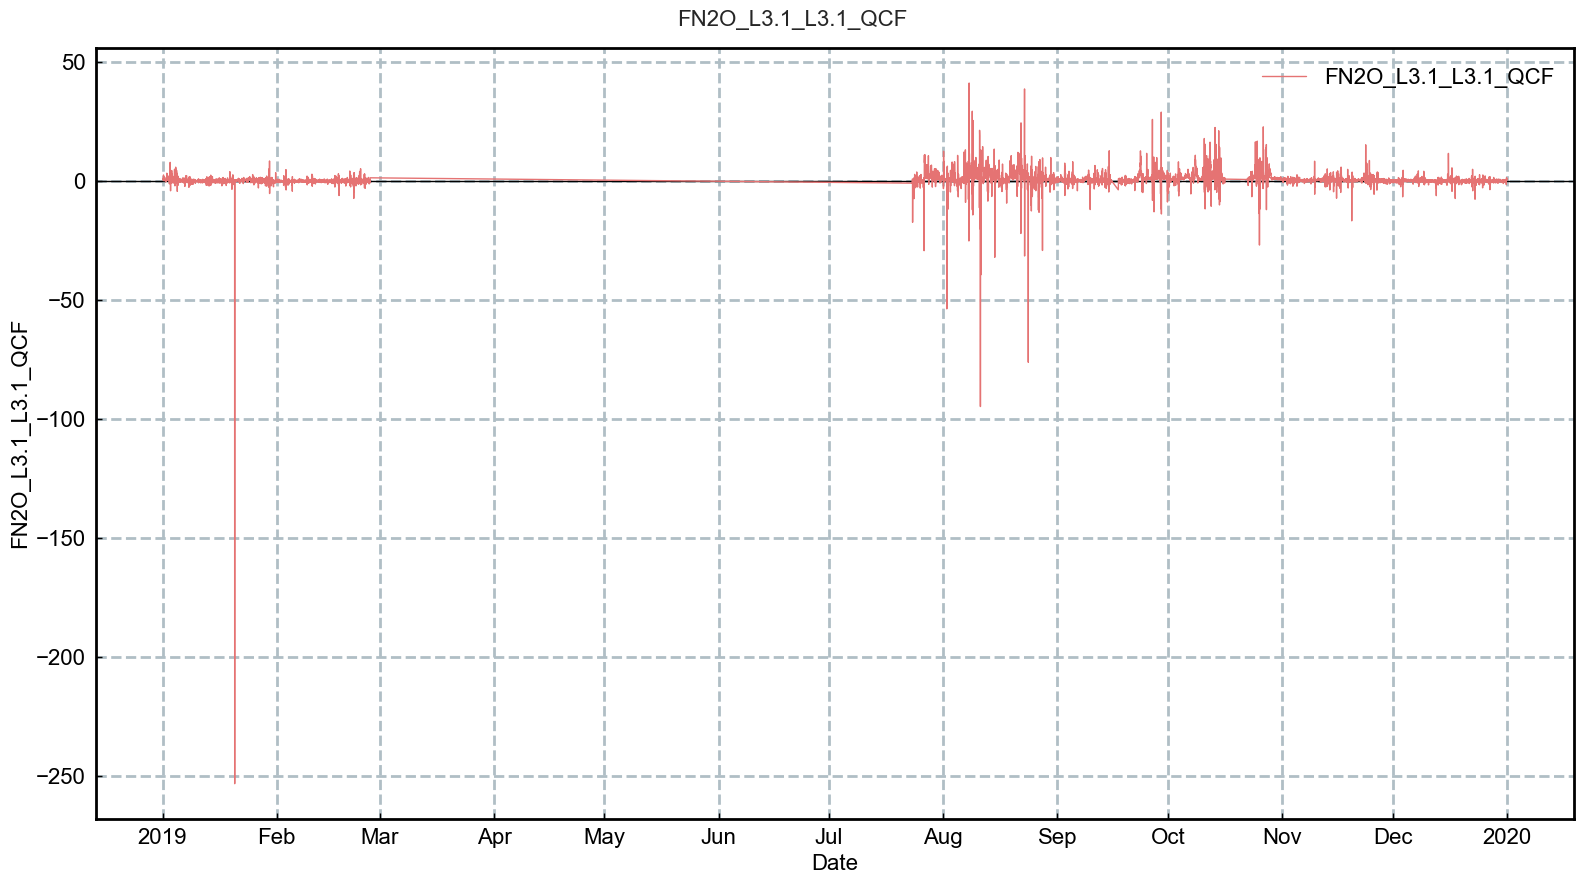

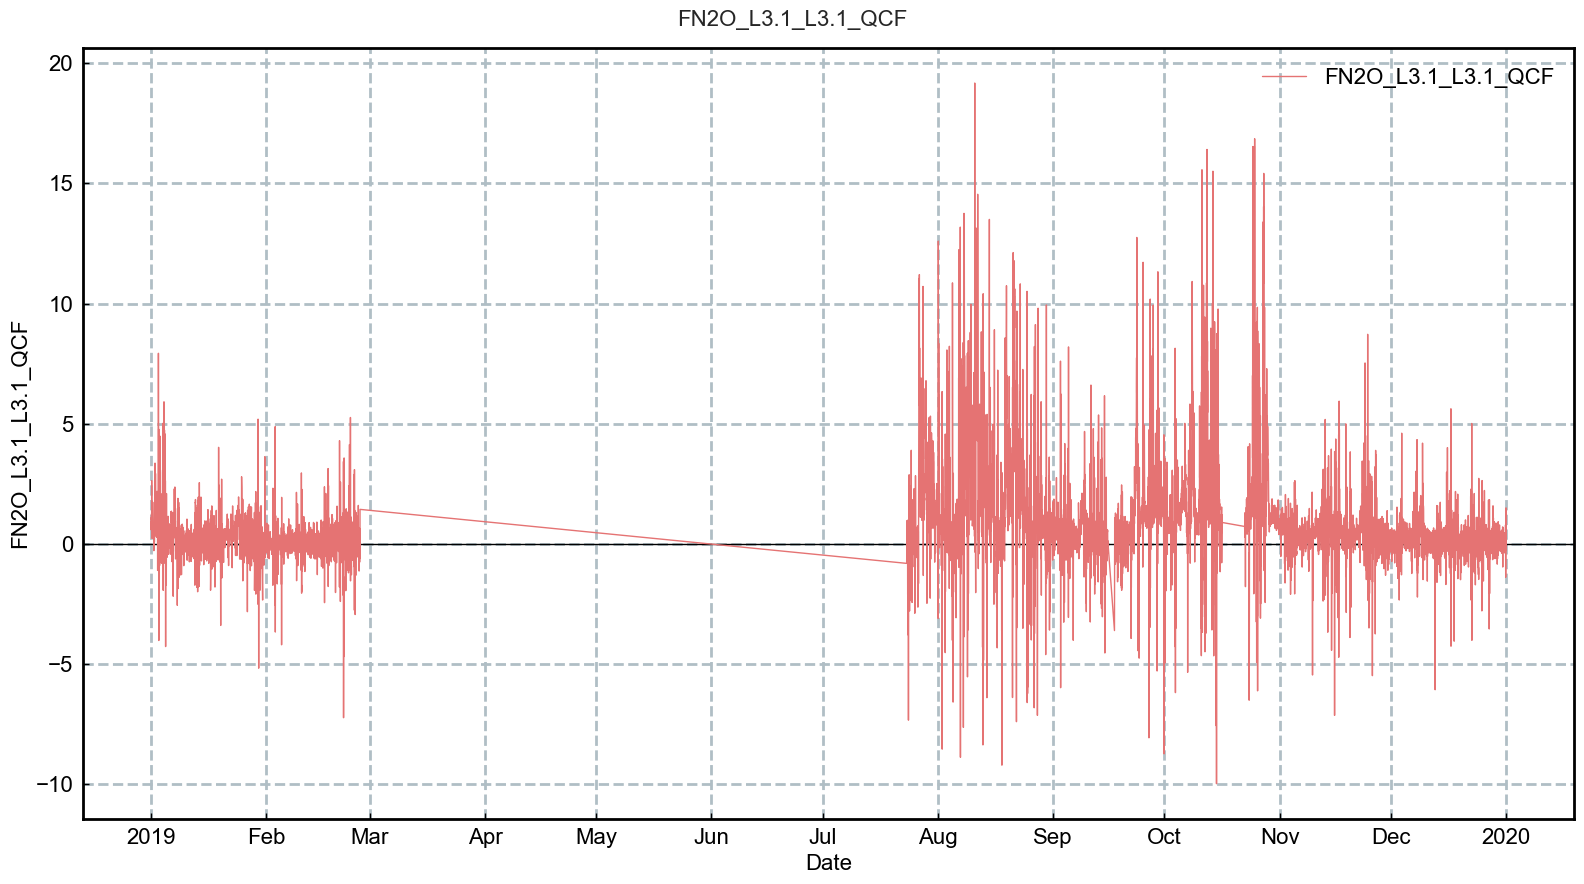

In [49]:
sod.showplot_orig()
sod.showplot_cleaned()

In [50]:
sod.addflag()

++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_STLRZ_TEST to flag data


</br>

</br>

## Flag, outlier detection: **Thymeboost**
- More info about [thymeboost](https://github.com/tblume1992/ThymeBoost)

In [ ]:
print(sod.flag_outliers_thymeboost_test.__doc__)
sod.flag_outliers_thymeboost_test(showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **Local outlier factor**

Local outlier factor, across all data


[LocalOutlierFactorAllData]  ========================================
[LocalOutlierFactorAllData]  LocalOutlierFactorAllData
[LocalOutlierFactorAllData]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOF_TEST for variable FN2O_L3.1_L3.1_QCF ...
[LocalOutlierFactorAllData]  Done.
[LocalOutlierFactorAllData]  ________________________________________
Total found outliers: 47 values (daytime)
Total found outliers: 47 values (daytime+nighttime)


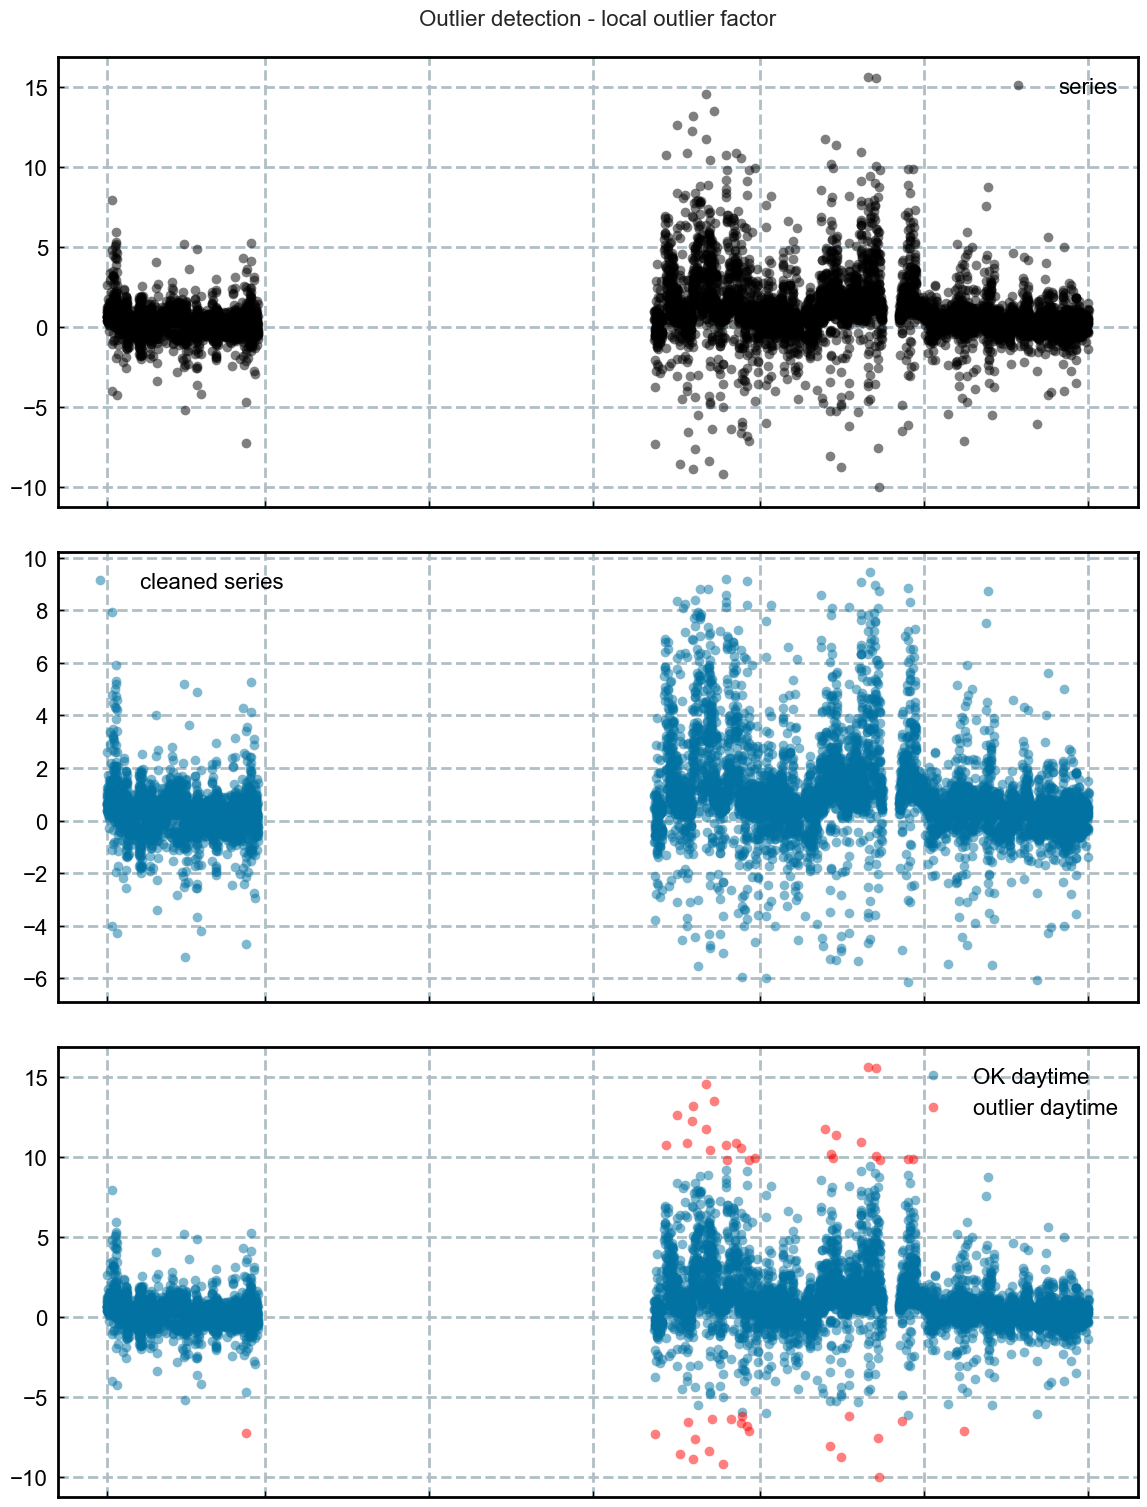

In [51]:
print(sod.flag_outliers_lof_test.__doc__)
sod.flag_outliers_lof_test(n_neighbors=None, contamination=0.005, showplot=True, verbose=True)

In [52]:
sod.addflag()

++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOF_TEST to flag data


</br>

</br>

## Flag, outlier detection: **Local outlier factor, daytime/nighttime**

Local outlier factor, separately for daytime and nighttime data


[LocalOutlierFactorDaytimeNighttime]  ========================================
[LocalOutlierFactorDaytimeNighttime]  LocalOutlierFactorDaytimeNighttime
[LocalOutlierFactorDaytimeNighttime]  ========================================
Generating flag FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOFDTNT_TEST for variable FN2O_L3.1_L3.1_QCF ...
Calculating sun altitude in 30T time resolution ...
Generating nighttime flag (1=nighttime, 0=daytime) from sun altitude ...
[LocalOutlierFactorDaytimeNighttime]  Done.
[LocalOutlierFactorDaytimeNighttime]  ________________________________________
Total found outliers: 2 values (daytime)
Total found outliers: 3 values (nighttime)
Total found outliers: 5 values (daytime+nighttime)


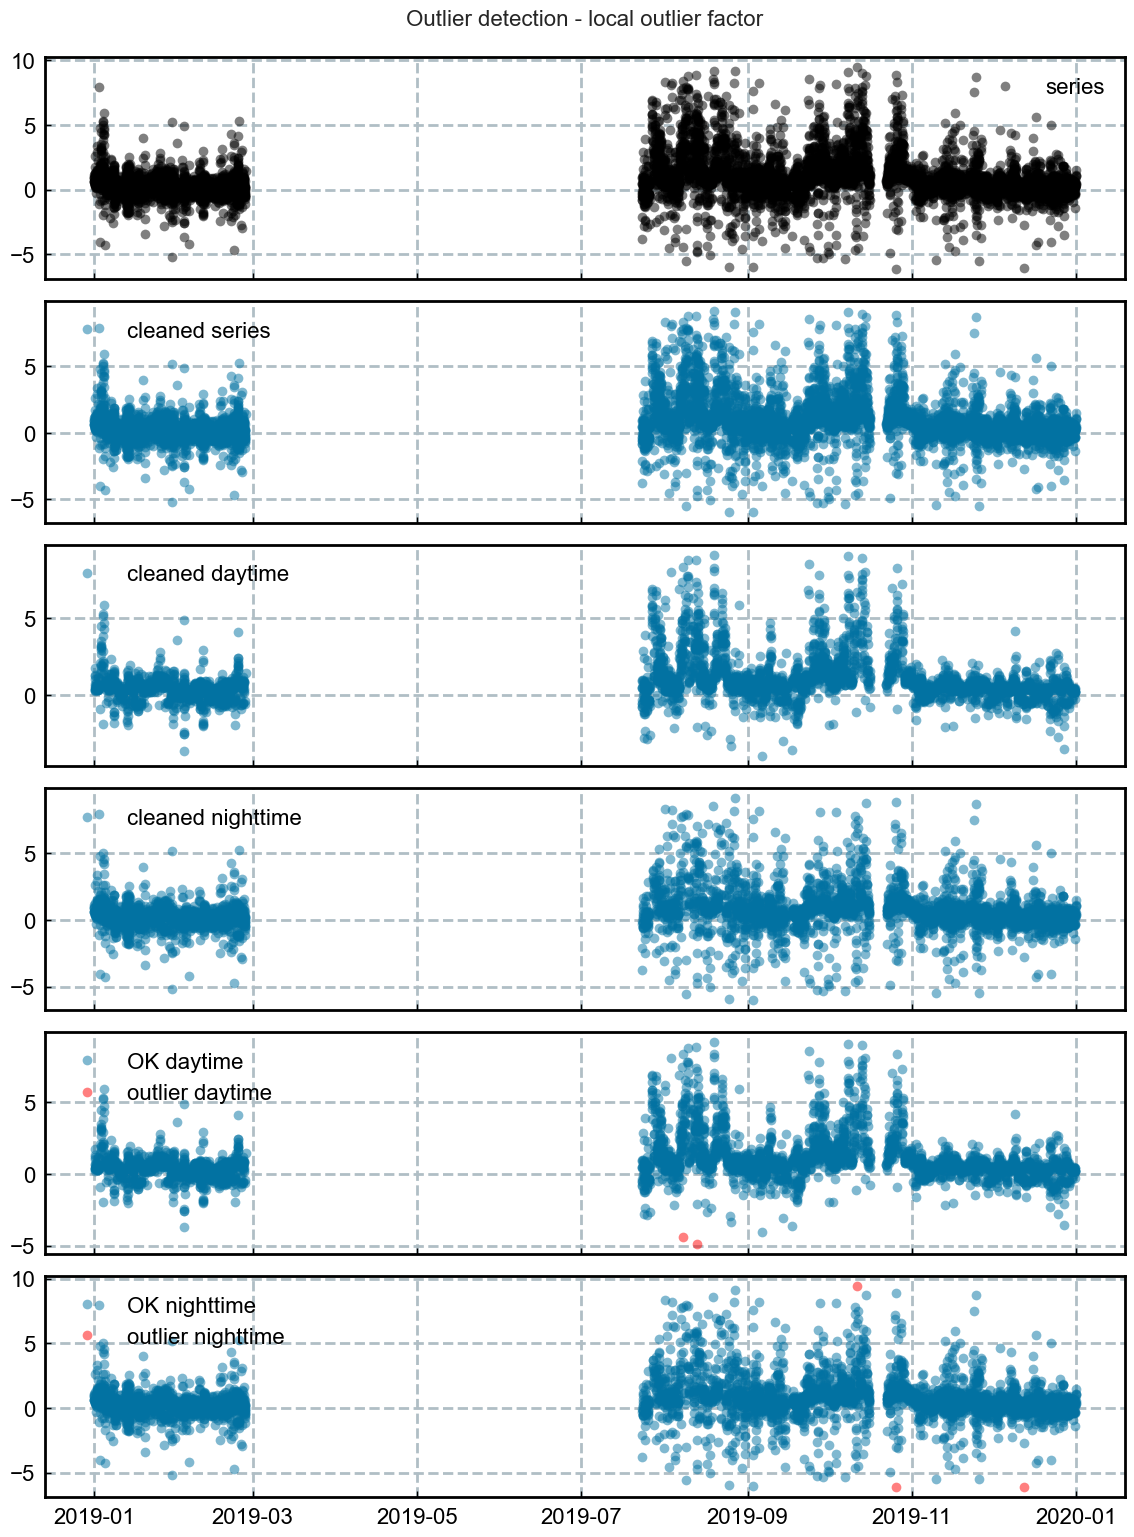

In [53]:
print(sod.flag_outliers_lof_dtnt_test.__doc__)
sod.flag_outliers_lof_dtnt_test(n_neighbors=None, contamination=0.0005, showplot=True, verbose=True)

In [54]:
sod.addflag()

++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOFDTNT_TEST to flag data


</br>

</br>

## Show outlier-cleaned flux

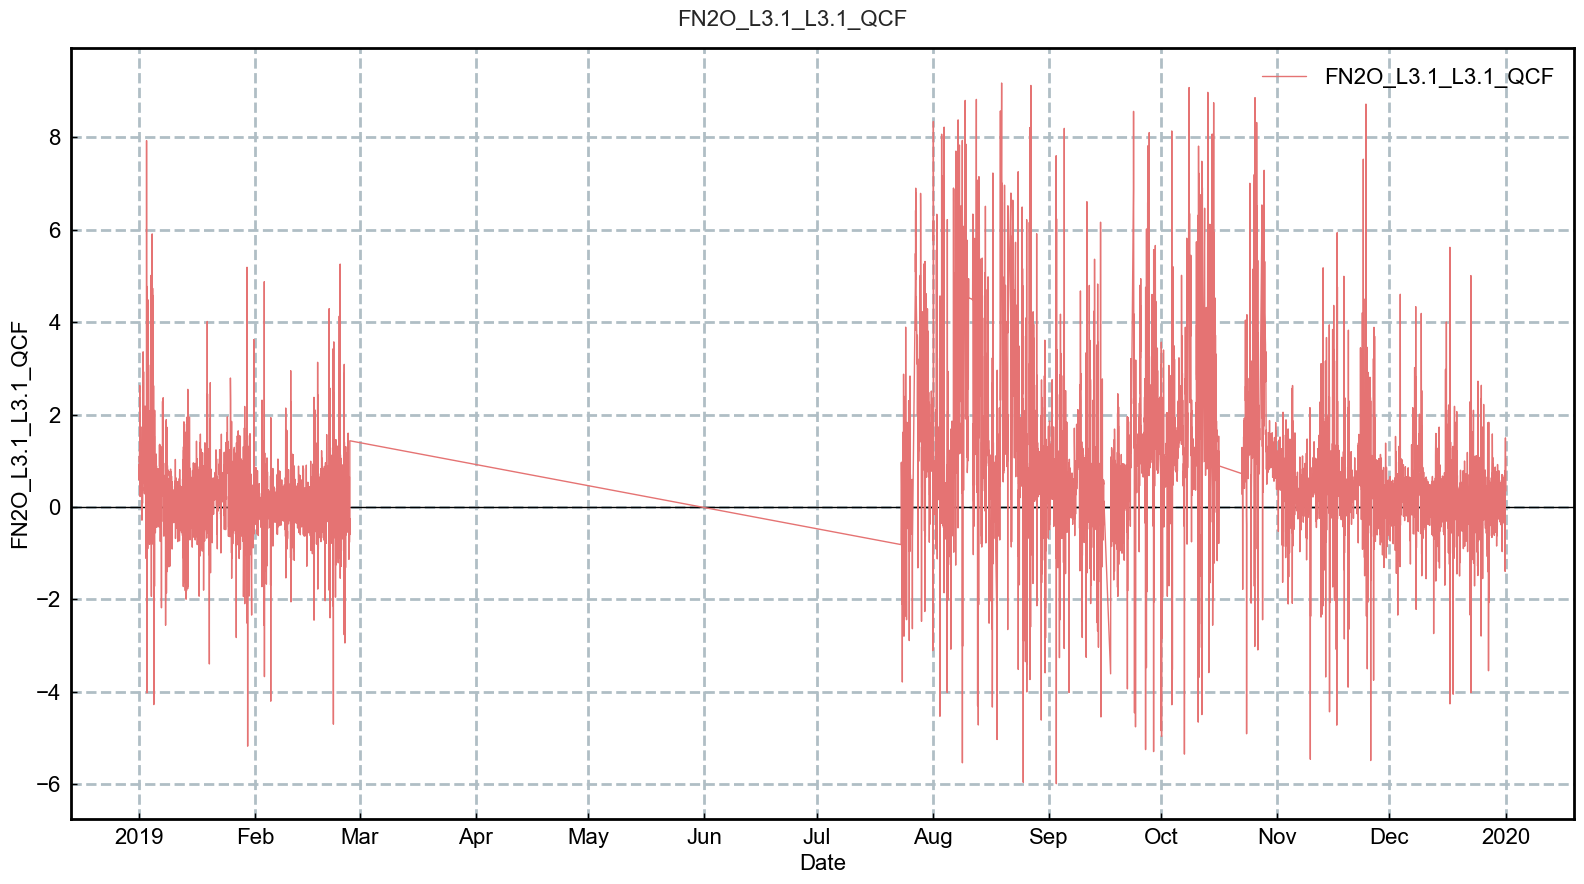

In [55]:
# sod.showplot_cleaned(interactive=True)
sod.showplot_cleaned(interactive=False)

</br>

</br>

## Finalize outlier detection: **Collect all flags**

In [56]:
df_level32 = sod.get()


Merging flags with full dataframe:
++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST as new column to full dataframe
++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ABSLIM_TEST as new column to full dataframe
++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST as new column to full dataframe
++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOCALSD_TEST as new column to full dataframe
++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_INCRZ_TEST as new column to full dataframe
++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_STLRZ_TEST as new column to full dataframe
++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOF_TEST as new column to full dataframe
++Added flag column FLAG_FN2O_L3.1_L3.1_QCF_OUTLIER_LOFDTNT_TEST as new column to full dataframe


</br>

## Generate `QCF`, needed for Level-3.3

In [57]:
qcf = FlagQCF(series=df_level32[FLUXVAR31], df=df_level32, levelid='L3.2', swinpot=df_level32['SW_IN_POT'], nighttime_threshold=50)
qcf.calculate(daytime_accept_qcf_below=2, nighttimetime_accept_qcf_below=2)
df_level32_qcf = qcf.get()

++Adding new column SUM_L3.2_FN2O_L3.1_HARDFLAGS to main data ...
++Adding new column SUM_L3.2_FN2O_L3.1_SOFTFLAGS to main data ...
++Adding new column SUM_L3.2_FN2O_L3.1_FLAGS to main data ...
++Adding new column FLAG_L3.2_FN2O_L3.1_QCF to main data ...
++Adding new column FN2O_L3.1_L3.2_QCF to main data ...


In [58]:
qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FN2O_L3.1.

Number of FN2O_L3.1 records before QC: 10073
+++ FLAG_L2_FN2O_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 10073 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FN2O_SSITC_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 10073 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FN2O_COMPLETENESS_TEST rejected 18 values (+0.18%)      TOTALS: flag 0: 10054 (99.81%) / flag 1: 1 (0.01%) / flag 2: 18 (0.18%)
+++ FLAG_L2_FN2O_SCF_TEST rejected 15 values (+0.15%)      TOTALS: flag 0: 9245 (91.78%) / flag 1: 795 (7.89%) / flag 2: 33 (0.33%)
+++ FLAG_L2_FN2O_N2O_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9245 (91.78%) / flag 1: 795 (7.89%) / flag 2: 33 (0.33%)
+++ FLAG_L2_FN2O_N2O_VM97_AMPLITUDE_RESOLUTION_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9245 (91.78%) /

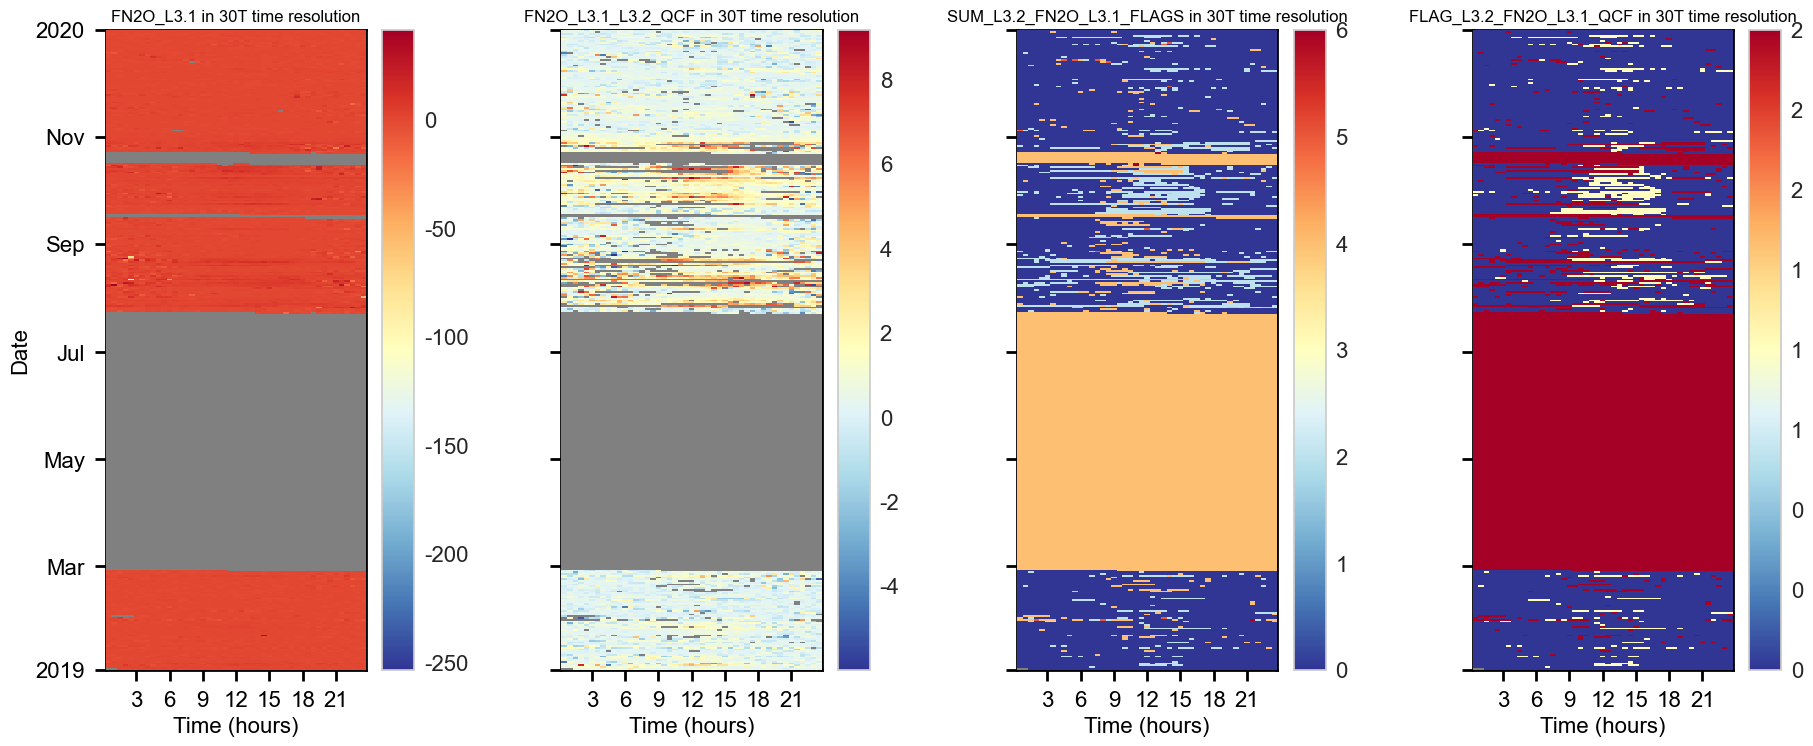

In [59]:
qcf.showplot_qcf_heatmaps()

In [60]:
qcf.report_qcf_series()



SUMMARY: FLAG_L3.2_FN2O_L3.1_QCF, QCF FLAG FOR FN2O_L3.1
Between 2019-01-01 01:15 and 2020-01-01 00:45 ...
    Total flux records BEFORE quality checks: 10073 (57.49% of potential)
    Available flux records AFTER quality checks: 9229 (91.62% of total)
    Rejected flux records: 844 (8.38% of total)
    Potential flux records: 17520
    Potential flux records missed: 7447 (42.51% of potential)



In [ ]:
qcf.report_qcf_flags()

In [ ]:
qcf.showplot_qcf_timeseries()

</br>

## Available `Level-3.2` variables after preliminary QCF
- This shows all available Level-3.2 variables, also the ones created previously for other fluxes

In [61]:
_vars = [print(x) for x in df_level32_qcf.columns if 'L3.2' in x]
FLUXVAR32QCF = f"{FLUXVAR31}_L3.2_QCF"  # Quality-controlled flux after Level-3.2
print(f"\nName of the storage-corrected and quality-controlled flux variable after Level-3.2:  {FLUXVAR32QCF}")

SUM_L3.2_FN2O_L3.1_HARDFLAGS
SUM_L3.2_FN2O_L3.1_SOFTFLAGS
SUM_L3.2_FN2O_L3.1_FLAGS
FLAG_L3.2_FN2O_L3.1_QCF
FN2O_L3.1_L3.2_QCF

Name of the storage-corrected and quality-controlled flux variable after Level-3.2:  FN2O_L3.1_L3.2_QCF


</br>

## Plot quality-controlled flux after `Level-3.2`
- Plot flux after storage-correction, flux quality control and outlier removal

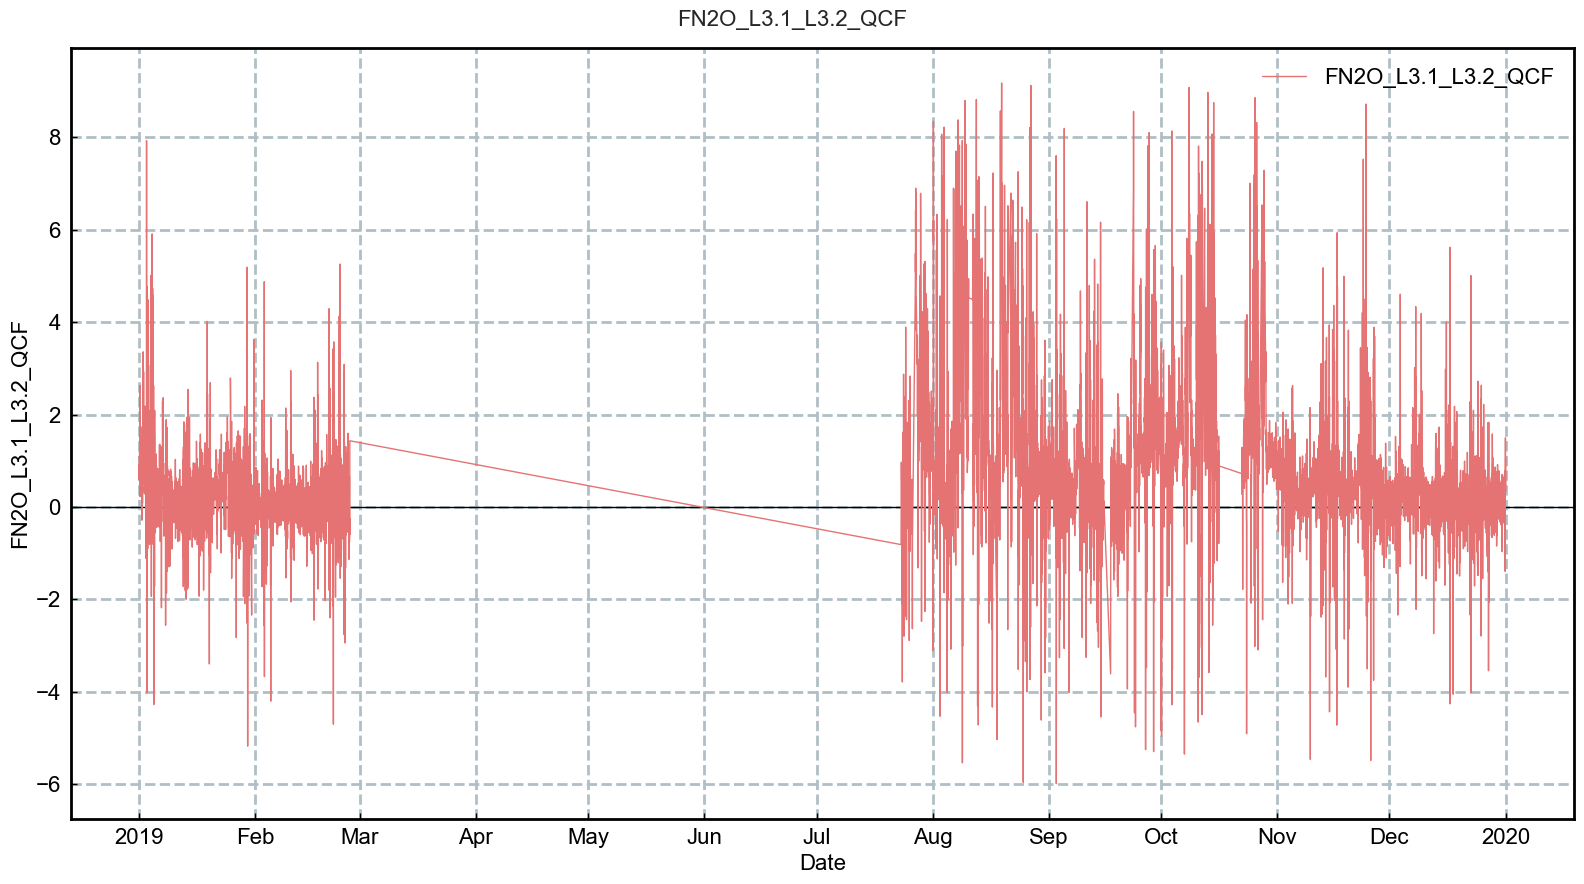

In [62]:
# TimeSeries(series=df_level32_qcf[FLUXVAR32QCF]).plot_interactive()
TimeSeries(series=df_level32_qcf[FLUXVAR32QCF]).plot()

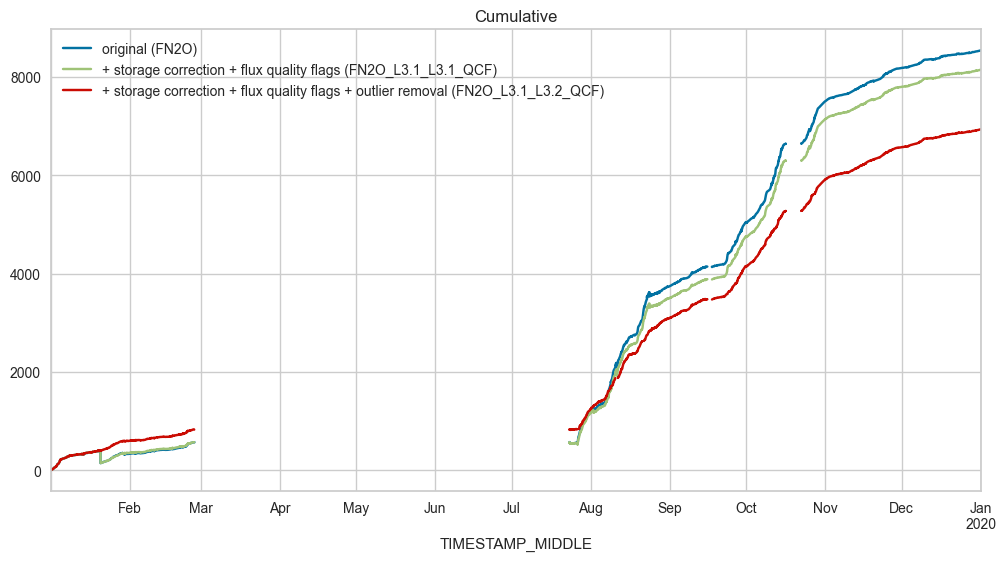

In [63]:
# Creating a dictionary by passing Series objects as values
frame = {
    f'original ({FLUXVAR})': df_level32_qcf[FLUXVAR],
    f'+ storage correction + flux quality flags ({FLUXVAR31QCF})': df_level32_qcf[FLUXVAR31QCF],    
    f'+ storage correction + flux quality flags + outlier removal ({FLUXVAR32QCF})': df_level32_qcf[FLUXVAR32QCF]
}

overview = pd.DataFrame(frame)
overview.cumsum().plot(title=f"Cumulative", figsize=(12, 6));

</br>

# **Overview after `Level-3.2`**

## Available `Level-3.2` fluxes

In [64]:
_fluxcols = [x for x in df_level32_qcf.columns if 'L3.1' and 'L3.2' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_') ]
_fluxcols

['FN2O_L3.1_L3.2_QCF']

In [65]:
_subset = df_level32_qcf[_fluxcols]
_subset

FN2O_L3.1_L3.2_QCF
TIMESTAMP_MIDDLE                       
2019-01-01 01:15:00            0.631518
2019-01-01 01:45:00            0.584300
2019-01-01 02:15:00            0.605795
2019-01-01 02:45:00            0.921723
2019-01-01 03:15:00            0.871920
...                                 ...
2019-12-31 22:45:00            1.015766
2019-12-31 23:15:00            1.494285
2019-12-31 23:45:00            1.103321
2020-01-01 00:15:00            0.337798
2020-01-01 00:45:00            1.051381

[17520 rows x 1 columns]

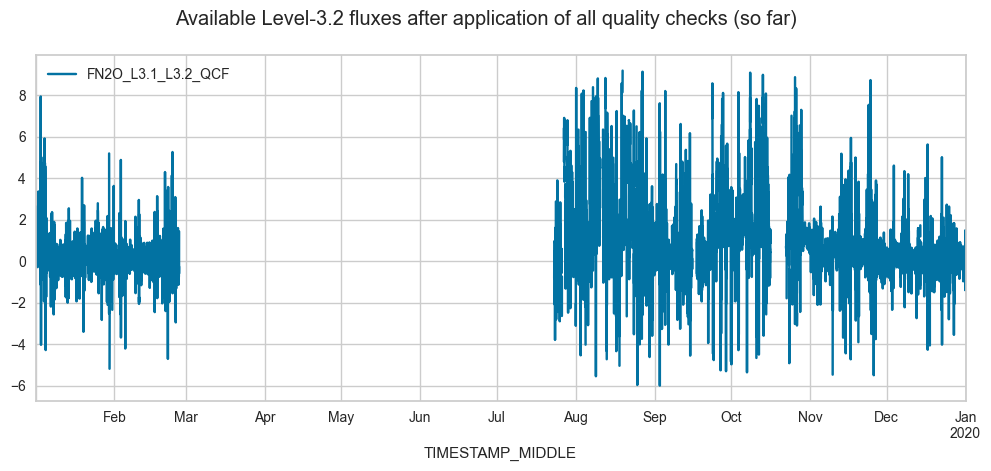

In [66]:
_subset.plot(subplots=True, title="Available Level-3.2 fluxes after application of all quality checks (so far)", figsize=(12, 4.5));

</br>

In [67]:
boxplots_df = df_level32_qcf[[FLUXVAR32QCF, "NIGHT"]].copy()
boxplots_df["DATE"] = boxplots_df.index.month
boxplots_df

FN2O_L3.1_L3.2_QCF  NIGHT  DATE
TIMESTAMP_MIDDLE                                    
2019-01-01 01:15:00            0.631518      1     1
2019-01-01 01:45:00            0.584300      1     1
2019-01-01 02:15:00            0.605795      1     1
2019-01-01 02:45:00            0.921723      1     1
2019-01-01 03:15:00            0.871920      1     1
...                                 ...    ...   ...
2019-12-31 22:45:00            1.015766      1    12
2019-12-31 23:15:00            1.494285      1    12
2019-12-31 23:45:00            1.103321      1    12
2020-01-01 00:15:00            0.337798      1     1
2020-01-01 00:45:00            1.051381      1     1

[17520 rows x 3 columns]

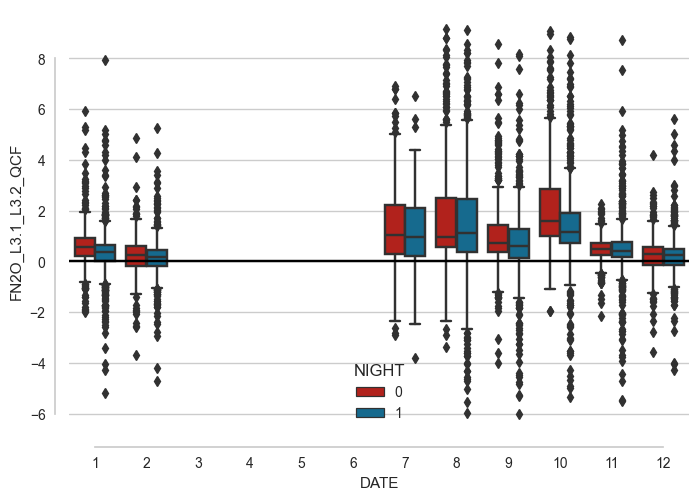

In [68]:
# sns.set_theme(style="ticks", palette="pastel")
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="DATE", y=FLUXVAR32QCF, palette=["r", "b"], hue="NIGHT", data=boxplots_df)
sns.despine(offset=10, trim=True)
plt.axhline(0, color="black");

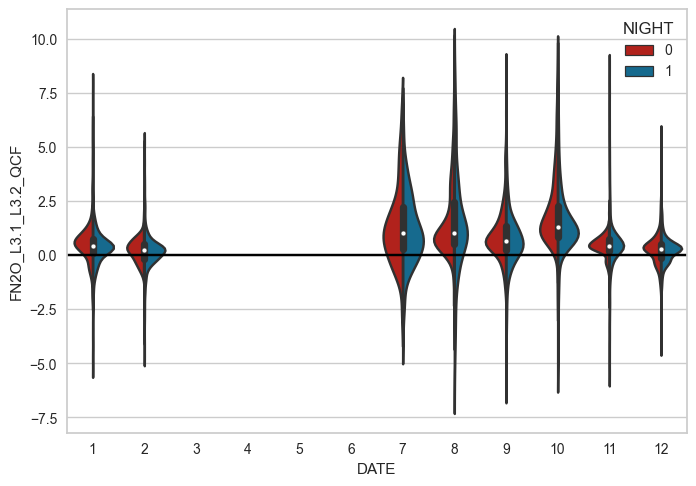

In [69]:
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=boxplots_df, x="DATE", y=FLUXVAR32QCF, hue="NIGHT", split=True, palette=["r", "b"]);
plt.axhline(0, color="black");

</br>

</br>

# **Save results to file**
- Save results to file for futher processing
- This can be useful if you want to use the data in another software, e.g. continuing post-processing using the library `ReddyProc` in `R` 
- `Parquet` format is recommended for large datasets

## Option 1: Save to CSV (large and slow)

In [ ]:
df_level32_qcf.to_csv("mylovelyhorse.csv")

## Option 2: Save to Parquet (small and fast)
- Needed if you want to continue post-processing in notebooks
- Can also be used in `R` with the `arrow` package

In [ ]:
save_parquet(data=df_level32_qcf, filename="df_level32_qcf")

</br>

# *(Preliminary) USTAR*

<div class="alert alert-block alert-danger">
    No USTAR filtering for: <b>H, LE, ET and FH2O.</b> 
</div>

> The USTAR filtering is not applied to H and LE, because it has not been proved that when there are CO2 advective fluxes, these also impact energy fluxes, specifically due to the fact that when advection is in general large (nighttime), energy fluxes are small.

source: [Pastorello et al. (2020). The FLUXNET2015 dataset and the ONEFlux processing pipeline for eddy covariance data](https://doi.org/10.1038/s41597-020-0534-3)



## *(Preliminary) Impact of different USTAR thresholds on data availability*



[UstarThresholdConstantScenarios]  ========================================
[UstarThresholdConstantScenarios]  UstarThresholdConstantScenarios
[UstarThresholdConstantScenarios]  ========================================
[UstarThresholdConstantScenarios]  Done.
[UstarThresholdConstantScenarios]  ________________________________________


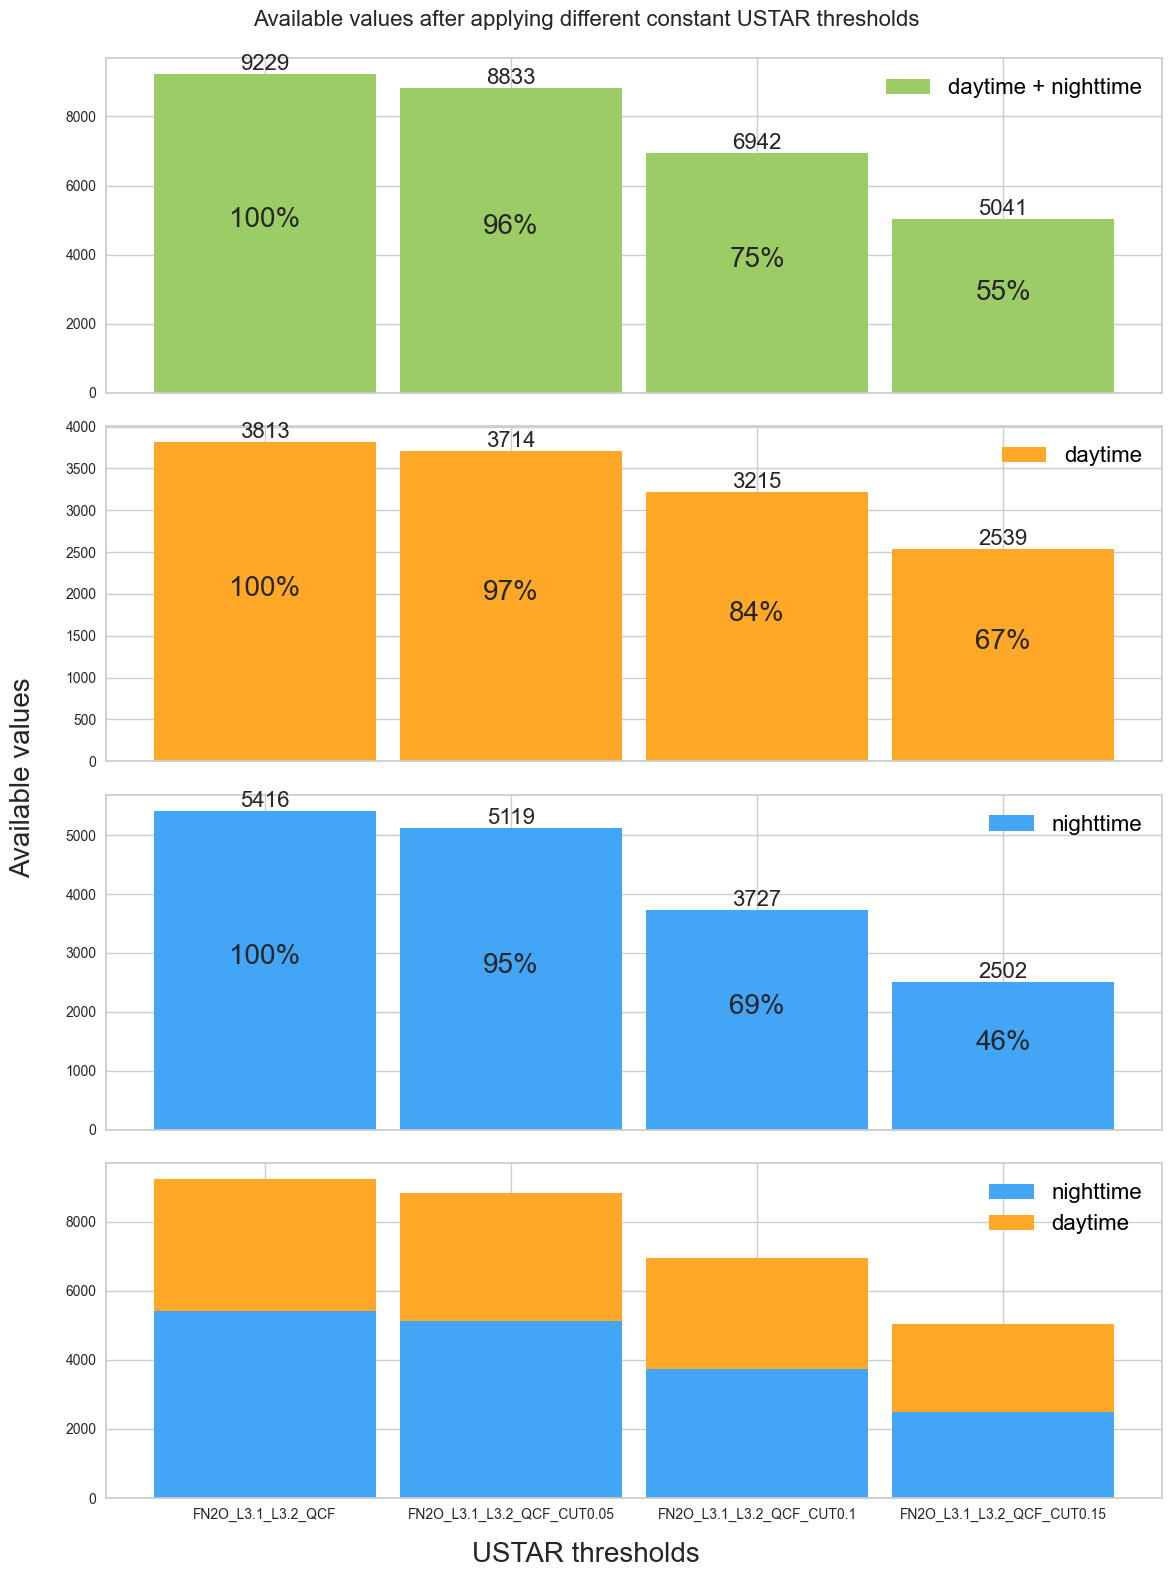

In [70]:
from diive.pkgs.flux.ustarthreshold import UstarThresholdConstantScenarios
ust = UstarThresholdConstantScenarios(series=df_level32_qcf[FLUXVAR32QCF],
                                      swinpot=df_level32_qcf['SW_IN_POT'],
                                      ustar=df_level32_qcf['USTAR'])
ust.calc(ustarthresholds=[0.05, 0.1, 0.15], showplot=True, verbose=True)

## *(Preliminary) Apply constant USTAR threshold*
- Use constant USTAR threshold for all data

(TODO)

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [71]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-10-30 16:05:01
